## INITIALIZING

In [1]:
import math
import numpy as np
import pandas as pd
import datetime
from scipy.interpolate import interp1d

import pyomo.environ as pyomo
import pulp

import os
import csv

import matplotlib
import matplotlib.pyplot as plt

In [2]:
# Plot Options
plt.rcParams['font.family'] = 'serif'
plt.rcParams.update({'font.size': 16})
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.5
plt.rcParams['axes.titlepad'] = 6.0
plt.rcParams['axes.labelpad'] = 2.0
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['figure.figsize'] = [12,6]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['scatter.edgecolors'] = 'face'
#matplotlib.rcParams.update(matplotlib.rcParamsDefault)

In [3]:
fpath="./"
os.chdir(fpath)

In [4]:
# Load the data
route_schedule = pd.read_csv('../data/route1_schedule.csv',index_col=0)
forecasts = pd.read_csv('../data/day1_forecasts.csv')

# Display the loaded data for inspection
print("Route Schedule Data:")
print(route_schedule)

print("\nDay 1 Forecasts Data:")
print(forecasts.head())

Route Schedule Data:
                      A          B          C          D           E
measure                                                             
eco-energy    38.052326  83.549407  36.335986  59.921933   66.783968
eco-time      28.998297  55.916802  27.284668  51.815136   56.051256
fast-energy   38.459771  83.988776  40.386108  80.917812   73.990403
fast-time     27.675135  54.819251  26.525876  44.685524   44.965860
stop-time     20.000000  30.000000  40.000000  30.000000  480.000000
stop-charger   0.000000   0.000000   1.000000   0.000000    1.000000

Day 1 Forecasts Data:
   time     price  emissions
0     0  152.6668       1016
1     5  152.6668       1010
2    10  152.6668       1010
3    15  152.6668       1010
4    20  152.6668       1010


In [5]:
# Define initial parameters
# start_time_nominal = 6.5 * 60  # 6:30 AM in minutes
start_time_nominal = 2.5 * 60  # 2:30 AM in minutes
min_start_shift = 2 * 60 # time shift (minutes) to set min possible start time
max_start_shift = 2 * 60 # time shift (minutes) to set max possible start time
start_time_lower_bound = start_time_nominal - min_start_shift
start_time_upper_bound = start_time_nominal + max_start_shift
battery_capacity = 256  # kWh
min_soc = 0.10 * battery_capacity  # 10% SOC
max_soc = 0.90 * battery_capacity  # 90% SOC
initial_soc = max_soc
delta_t = 1 # 1-minute intervals

# Extract relevant data from route_schedule
eco_energy = route_schedule.iloc[0, :].dropna().values
eco_time = route_schedule.iloc[1, :].dropna().values
stop_times = route_schedule.iloc[4, :].dropna().values
can_charge = route_schedule.iloc[5, :].dropna().astype(bool).values

# Extract relevant grid data
electricity_price = forecasts['price'].values / 1000  # converting to $/kWh
carbon_intensity = forecasts['emissions'].values / 1000 # converting to kgCO2/kWh
time_index = forecasts['time'].values
#time_index = np.arange(0, len(forecasts) * 5, 5)

# Add extra datapoint at 1440
time_index = np.append(time_index, 1440)
electricity_price = np.append(electricity_price, electricity_price[-1])
carbon_intensity = np.append(carbon_intensity, carbon_intensity[-1])

# Setup function to interpolate original carbon data
f_interp = interp1d(time_index, carbon_intensity, kind='linear')

# Interpolate input data to get 1 minute resolution
time_index = np.arange(0, 1441)  # 0 to 1440 inclusive
electricity_price = np.repeat(electricity_price[:-1], 5)
electricity_price = np.append(electricity_price, electricity_price[-1])  # add the last value
carbon_intensity = f_interp(time_index)

# Initial energy list (cumulative energy consumption)
energy_list = np.cumsum(np.insert(eco_energy, 0, 0))

# Calculate the required charge
required_charge = energy_list[-1] - max_soc + min_soc

# Augmented energy list with stops
augmented_energy_list = []
for i in range(len(energy_list)):
    if i!=0:
        augmented_energy_list.append(energy_list[i])
    if i < len(energy_list) - 1:
        augmented_energy_list.append(energy_list[i])

# Augmented energy list with charging
# NOTE: Naive assumption that only one on-route charger is used
if required_charge > 0:
    for i in range(len(augmented_energy_list)):
        if i!=0 and i % 2 == 0 and can_charge[(i-1) // 2]:
            for j in range(i,len(augmented_energy_list)):
                augmented_energy_list[j] -= required_charge
            break

# Augmented energy list should end with 0 to indicate charging back to full
augmented_energy_list.append(0)

# Remaining energy list
remaining_energy_list = [max_soc-e for e in augmented_energy_list]

# Time list with stops
time_list = [0]
for i in range(len(eco_time)):
    time_list.append(time_list[-1] + eco_time[i])
    time_list.append(time_list[-1] + stop_times[i])

# Isolate charging time windows
charge_windows = []
for i in range(1,len(time_list)):
    if i % 2 == 0 and can_charge[(i-1) // 2]:
        charge_windows.append((time_list[i-1], time_list[i]))

# Ensure bounds are within acceptable limits
start_time_lower_bound = max(0, start_time_lower_bound)
start_time_upper_bound = min(1440 - time_list[-1], start_time_upper_bound)

# Verify the constructed lists
print("Time List:\n", time_list)
print("Augmented Energy List:\n", augmented_energy_list)
print("Remaining Energy List:\n", remaining_energy_list)
print("Charge Windows:\n",charge_windows)

Time List:
 [0, 28.9982971, 48.9982971, 104.91509930000001, 134.9150993, 162.1997676, 202.1997676, 254.01490330000001, 284.0149033, 340.0661595, 820.0661595]
Augmented Energy List:
 [0.0, 38.0523265, 38.0523265, 121.601733, 121.601733, 157.93771859999998, 78.09409849999997, 138.01603179999998, 138.01603179999998, 204.8, 0]
Remaining Energy List:
 [230.4, 192.3476735, 192.3476735, 108.79826700000001, 108.79826700000001, 72.46228140000002, 152.30590150000003, 92.38396820000003, 92.38396820000003, 25.599999999999994, 230.4]
Charge Windows:
 [(162.1997676, 202.1997676), (340.0661595, 820.0661595)]


In [6]:
# Save 1-minute interval data
time_index.tofile("./time_index.txt",sep="\n")
electricity_price.tofile("./electricity_price.txt",sep="\n")
carbon_intensity.tofile("./carbon_intensity.txt",sep="\n")

## Initial Plot

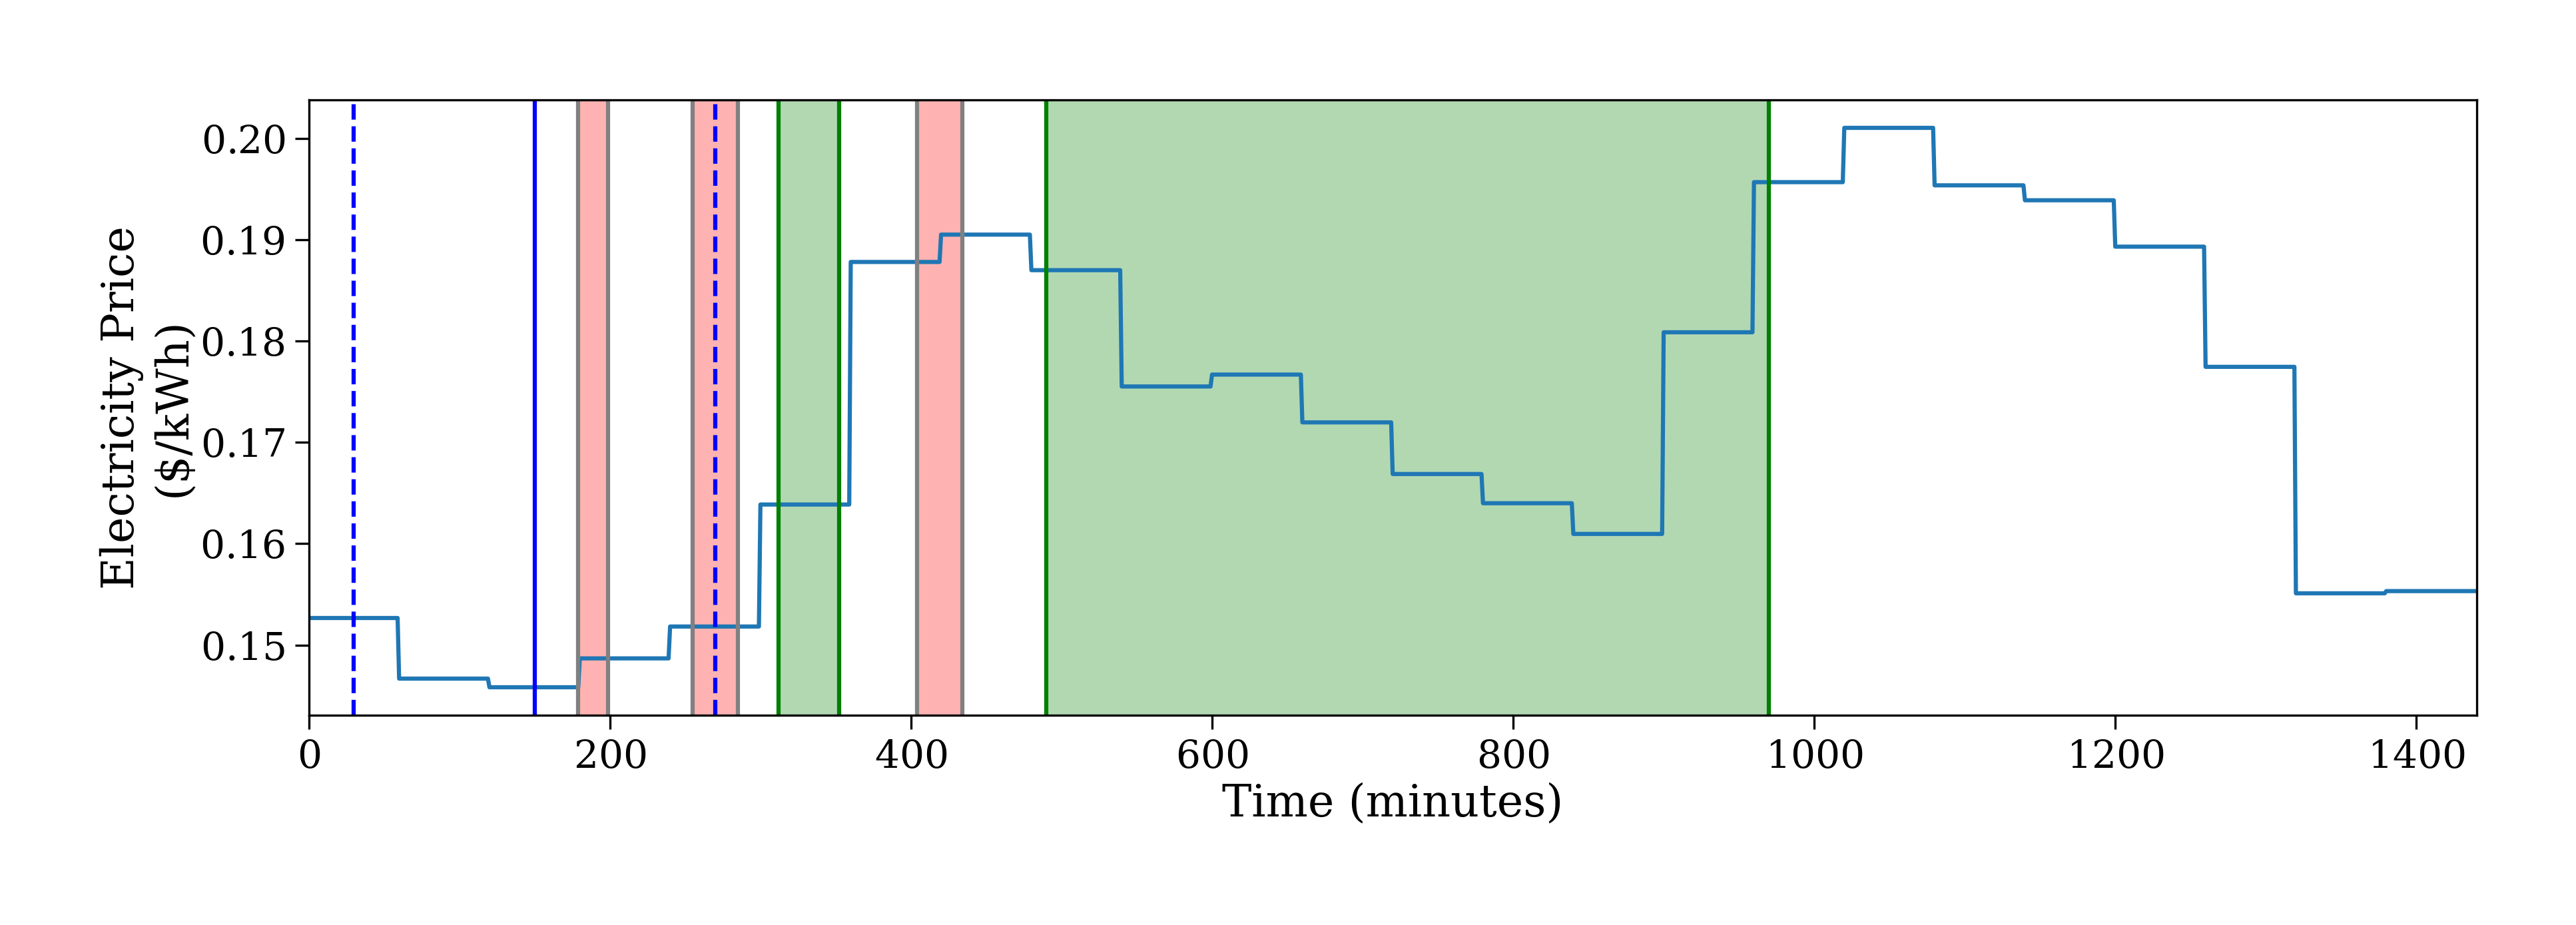

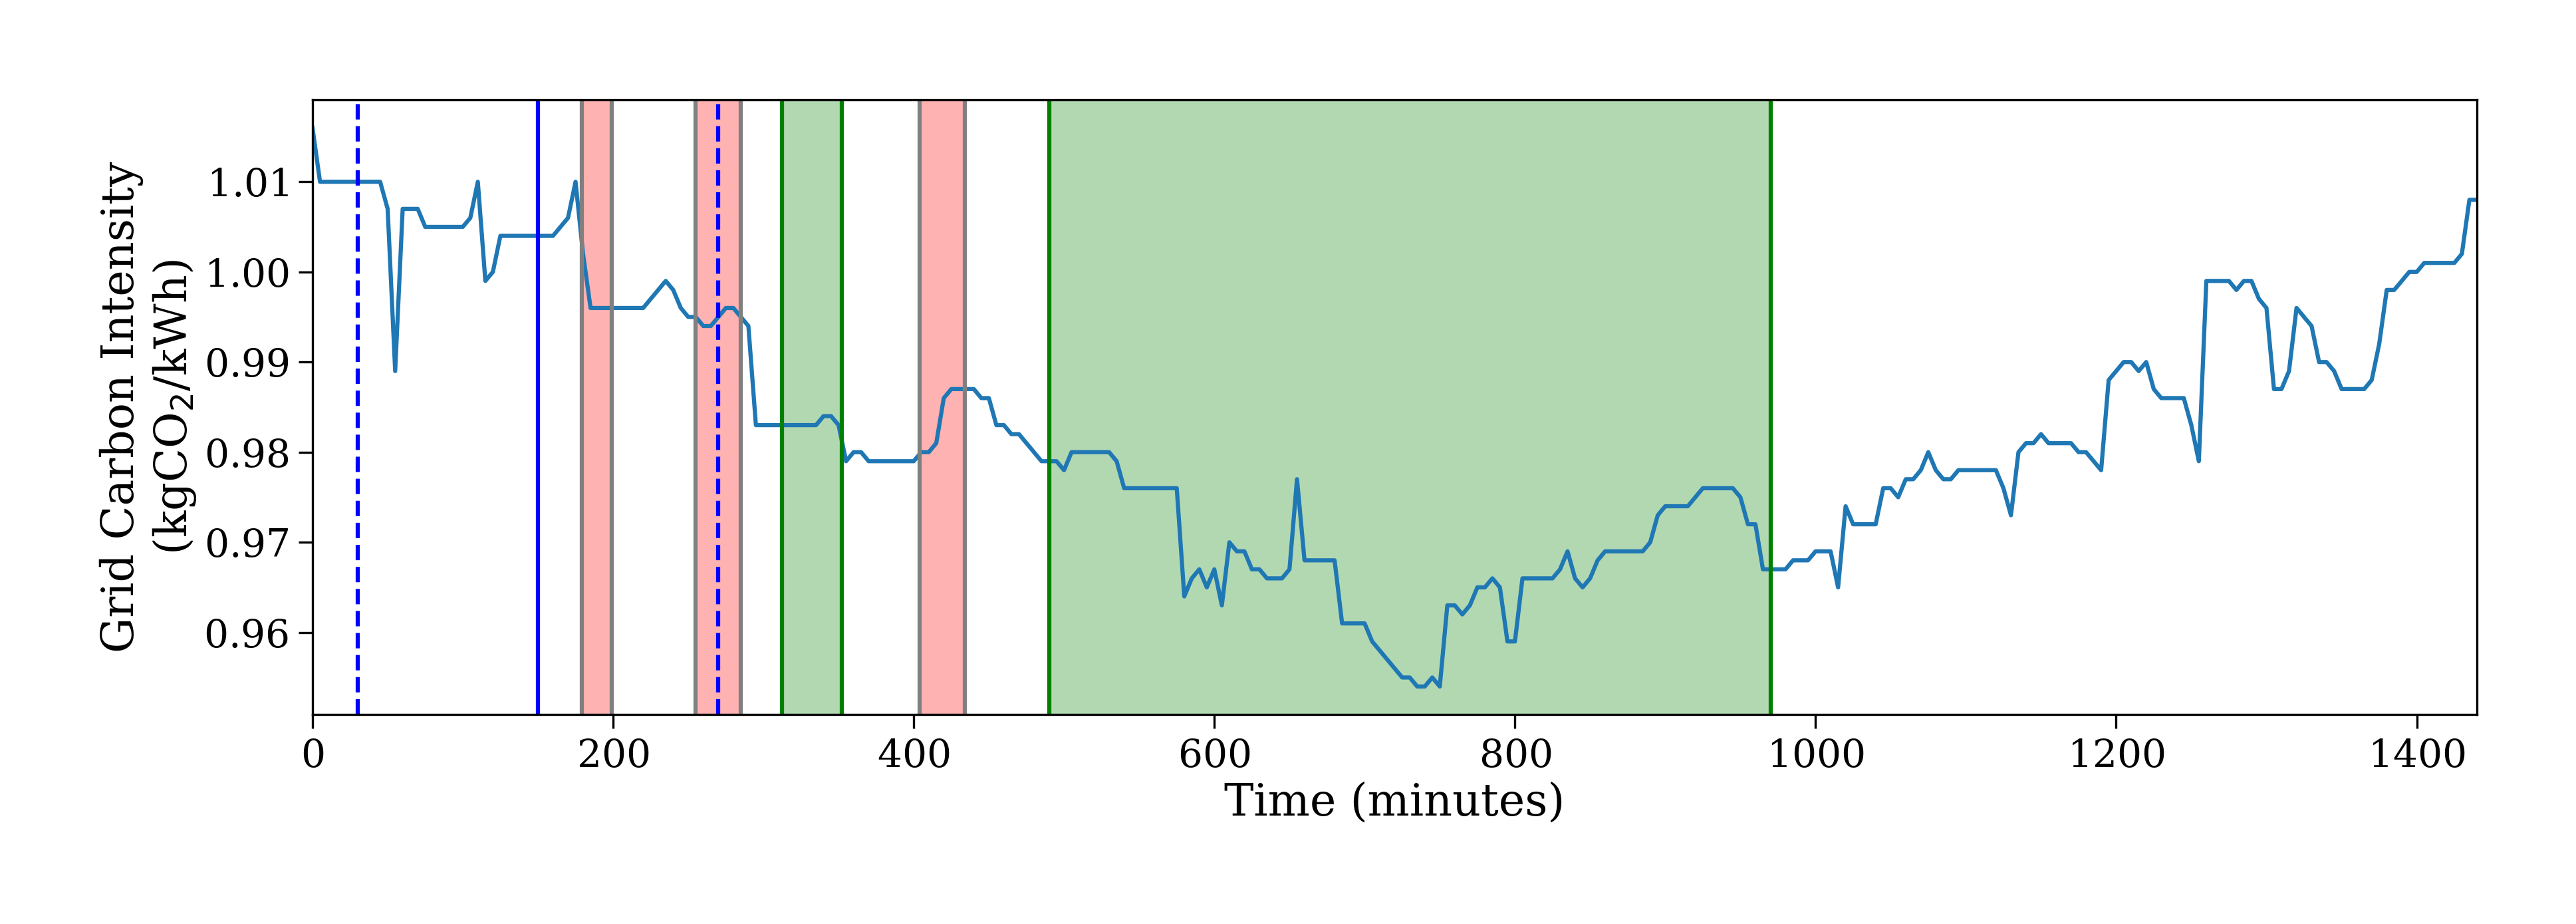

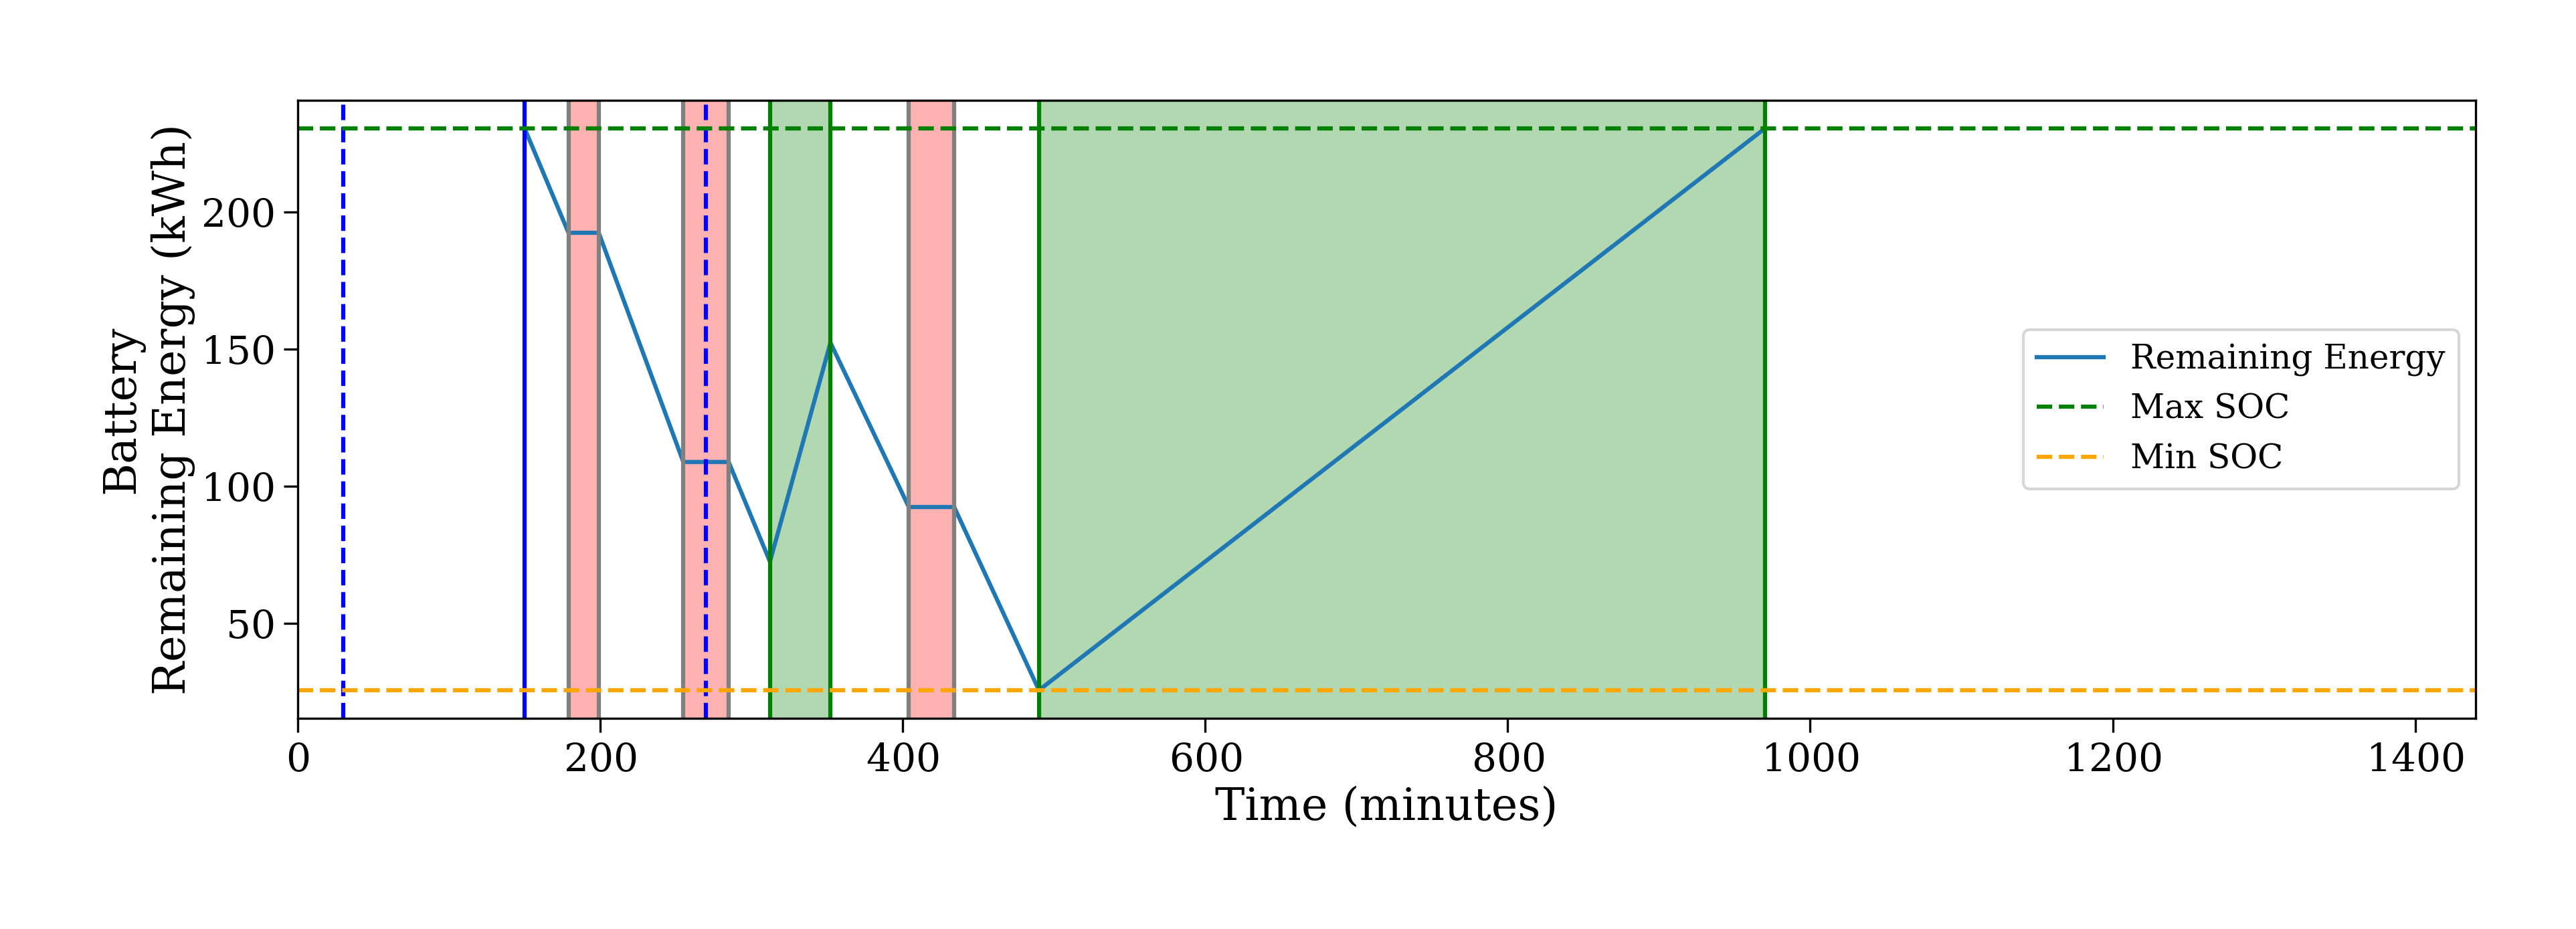

In [7]:
# Plot electricity price
fig1, ax1 = plt.subplots(figsize=(14, 4))
ax1.plot(time_index, electricity_price, label='Electricity Price')

# Mark transition points
for i in range(len(time_list)):
    if time_list[i] == 0:
        ax1.axvline(x=start_time_nominal + time_list[i], color='b', linestyle='-')
    elif can_charge[(i-1) // 2]:
        ax1.axvline(x=start_time_nominal + time_list[i], color='g', linestyle='-')
    else:
        ax1.axvline(x=start_time_nominal + time_list[i], color='grey', linestyle='-')
        if i % 2 == 0:
            ax1.axvspan(start_time_nominal + time_list[i-1], start_time_nominal + time_list[i], facecolor='red', alpha=0.3)
    if time_list[i] != 0 and i % 2 == 0 and can_charge[(i-1) // 2]:
        ax1.axvspan(start_time_nominal + time_list[i-1], start_time_nominal + time_list[i], facecolor='green', alpha=0.3)

# Mark bounds for start time
ax1.axvline(x=start_time_lower_bound, color='b', linestyle='--')
ax1.axvline(x=start_time_upper_bound, color='b', linestyle='--')

# Set labels
ax1.set_ylabel('Electricity Price\n($/kWh)')
ax1.set_xlabel('Time (minutes)')
ax1.set_xlim(0, 1440)

plt.show()

# Plot grid carbon intensity
fig2, ax2 = plt.subplots(figsize=(14, 4))
ax2.plot(time_index, carbon_intensity, label='Grid Carbon Intensity')

# Mark transition points
for i in range(len(time_list)):
    if time_list[i] == 0:
        ax2.axvline(x=start_time_nominal + time_list[i], color='b', linestyle='-')
    elif can_charge[(i-1) // 2]:
        ax2.axvline(x=start_time_nominal + time_list[i], color='g', linestyle='-')
    else:
        ax2.axvline(x=start_time_nominal + time_list[i], color='grey', linestyle='-')
        if i % 2 == 0:
            ax2.axvspan(start_time_nominal + time_list[i-1], start_time_nominal + time_list[i], facecolor='red', alpha=0.3)
    if time_list[i] != 0 and i % 2 == 0 and can_charge[(i-1) // 2]:
        ax2.axvspan(start_time_nominal + time_list[i-1], start_time_nominal + time_list[i], facecolor='green', alpha=0.3)

# Mark bounds for start time
ax2.axvline(x=start_time_lower_bound, color='b', linestyle='--')
ax2.axvline(x=start_time_upper_bound, color='b', linestyle='--')

# Set labels
ax2.set_ylabel('Grid Carbon Intensity\n(kgCO$_2$/kWh)')
ax2.set_xlabel('Time (minutes)')
ax2.set_xlim(0, 1440)

plt.show()

# Plot the final results for remaining battery energy
fig3, ax3 = plt.subplots(figsize=(14, 4))
ax3.plot([start_time_nominal + t for t in time_list], remaining_energy_list, label='Remaining Energy')

# Mark transition points and optimized charging windows
for i in range(len(time_list)):
    if time_list[i] == 0:
        ax3.axvline(x=start_time_nominal + time_list[i], color='b', linestyle='-')
    elif can_charge[(i-1) // 2]:
        ax3.axvline(x=start_time_nominal + time_list[i], color='g', linestyle='-')
    else:
        ax3.axvline(x=start_time_nominal + time_list[i], color='grey', linestyle='-')
        if i % 2 == 0:
            ax3.axvspan(start_time_nominal + time_list[i-1], start_time_nominal + time_list[i], facecolor='red', alpha=0.3)
    if time_list[i] != 0 and i % 2 == 0 and can_charge[(i-1) // 2]:
        ax3.axvspan(start_time_nominal + time_list[i-1], start_time_nominal + time_list[i], facecolor='green', alpha=0.3)

# Mark bounds for start time
ax3.axvline(x=start_time_lower_bound, color='b', linestyle='--')
ax3.axvline(x=start_time_upper_bound, color='b', linestyle='--')

# Plot
ax3.axhline(y=max_soc, color='g', linestyle='--', label='Max SOC')
ax3.axhline(y=min_soc, color='orange', linestyle='--', label='Min SOC')

# Set labels
ax3.set_ylabel('Battery\nRemaining Energy (kWh)')
ax3.set_xlabel('Time (minutes)')
ax3.set_xlim(0, 1440)
ax3.legend()

plt.show()

In [8]:
def window_builder(charge_flag):
    indexes = [i for i, val in enumerate(charge_flag) if val == 1]
    windows = []
    a = 0
    b = 0
    for i in range(len(indexes)):
        if i == 0 :
            a = indexes[i]
        elif i == len(indexes) - 1:
            b = indexes[-1]
        elif indexes[i] - indexes[i-1] > 1 :
            b = indexes[i-1]
            windows.append((a,b))
            a = indexes[i]
    windows.append((a,b))
    return windows


In [9]:
def winows_lower(c_t,windows,charge_flag):
    charge_flag_new = [0] * len(charge_flag)
    (a,b) = windows
    j = 0
    for i in range(a,b):
        if c_t[j] > 0:
            charge_flag_new[i] = 50
        j = j + 1
    
    return charge_flag_new

In [10]:
def save_plot(fig, filename):
    fig.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close(fig)

# Route Scheduling - Higher Level Schedule

## MIP Optimization

In [11]:
def milp(lambd,electricity_price,carbon_intensity,time_index,start_time_nominal,start_time_lower_bound,start_time_upper_bound,charge_windows):
    price_dict = dict(zip(time_index, electricity_price))
    emission_dict = dict(zip(time_index, carbon_intensity))

    # Create duration_dict with the time gap over which the current measure is valid
    duration_dict = {t: 1/60 for t in time_index}
    # Initialize optimization problem
    prob = pulp.LpProblem("Schedule_Route_Start", pulp.LpMinimize)

    # Declare time index variable
    #time = pulp.LpVariable.dicts("t", time_index, cat='Continuous')

    # Declare decision variable(s)
    t0 = pulp.LpVariable("t0", lowBound=start_time_lower_bound, upBound=start_time_upper_bound, cat='Integer')
    charge_window_dict = pulp.LpVariable.dicts("in_window", time_index, cat='Binary')

    # Add objective function to problem first
    prob += pulp.lpSum([charge_window_dict[t] * (price_dict[t] + lambd * emission_dict[t]) * duration_dict[t] for t in time_index])

    # Create auxiliary binary variables for each charge window
    charge_window_vars = {}
    for i, (start, end) in enumerate(charge_windows):
        rounded_start = round(start)-0.001   # NOTE: count cost from first minute (change with -0.001)
        rounded_end = round(end)-0.001 # NOTE: do not count cost from extra minute (change with -0.001)
        charge_window_vars[i] = pulp.LpVariable.dicts(f"window_{i}", time_index, lowBound=0, upBound=1, cat='Binary')
        for t in time_index:
            # Create auxiliary variables to check if t is within the charge window
            within_window_start = pulp.LpVariable(f"within_window_start_{i}_{t}", cat='Binary')
            within_window_end = pulp.LpVariable(f"within_window_end_{i}_{t}", cat='Binary')

            prob += within_window_start <= (t - (rounded_start + t0)) / 1440 + 1
            prob += within_window_start >= (t - (rounded_start + t0)) / 1440

            prob += within_window_end <= ((rounded_end + t0) - t) / 1440 + 1
            prob += within_window_end >= ((rounded_end + t0) - t) / 1440

            prob += charge_window_vars[i][t] <= within_window_start
            prob += charge_window_vars[i][t] <= within_window_end
            prob += charge_window_vars[i][t] >= within_window_start + within_window_end - 1

    # Combine charge window variables to determine if the time falls within any window
    for t in time_index:
        prob += charge_window_dict[t] == pulp.lpSum([charge_window_vars[i][t] for i in range(len(charge_windows))])

    # Option: set desired t0 to show computed cost
    #prob += t0 == 130.

    # Solve the problem
    prob.solve()
    # Get the optimized start time
    optimized_start_time = pulp.value(t0)
# Evaluate the total cost with the optimized values
    optimized_total_cost = sum(
        pulp.value(charge_window_dict[t]) * (price_dict[t] + lambd * emission_dict[t]) * duration_dict[t]
        for t in time_index
    )

    charge_flag = [pulp.value(charge_window_dict[t]) for t in time_index]

    return optimized_start_time, optimized_total_cost , charge_flag

# Set hyperparameter
lambd = 0.18

optimized_start_time, optimized_total_cost , charge_flag= milp(lambd,electricity_price,carbon_intensity,time_index,start_time_nominal,start_time_lower_bound,start_time_upper_bound,charge_windows)

mip_windows = window_builder(charge_flag)

print("\nLambda:", lambd)

print("Optimized Start Time:", optimized_start_time)

print("Optimized Total Cost:", optimized_total_cost)


print("Charging windows:", mip_windows)



Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l_/9_zfnc1528j4t0x96tq52wdh0000gn/T/541485e2aa60472686e433b5f2beab73-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l_/9_zfnc1528j4t0x96tq52wdh0000gn/T/541485e2aa60472686e433b5f2beab73-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 21620 COLUMNS
At line 90791 RHS
At line 112407 BOUNDS
At line 122497 ENDATA
Problem MODEL has 21615 rows, 10088 columns and 47553 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.41 seconds
Cgl0003I 4 fixed, 0 tightened bounds, 135 strengthened rows, 808 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 0 strengthened rows, 76 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 228 strengthened rows, 217 substitutions
Cgl0003I 0 fixed, 0 

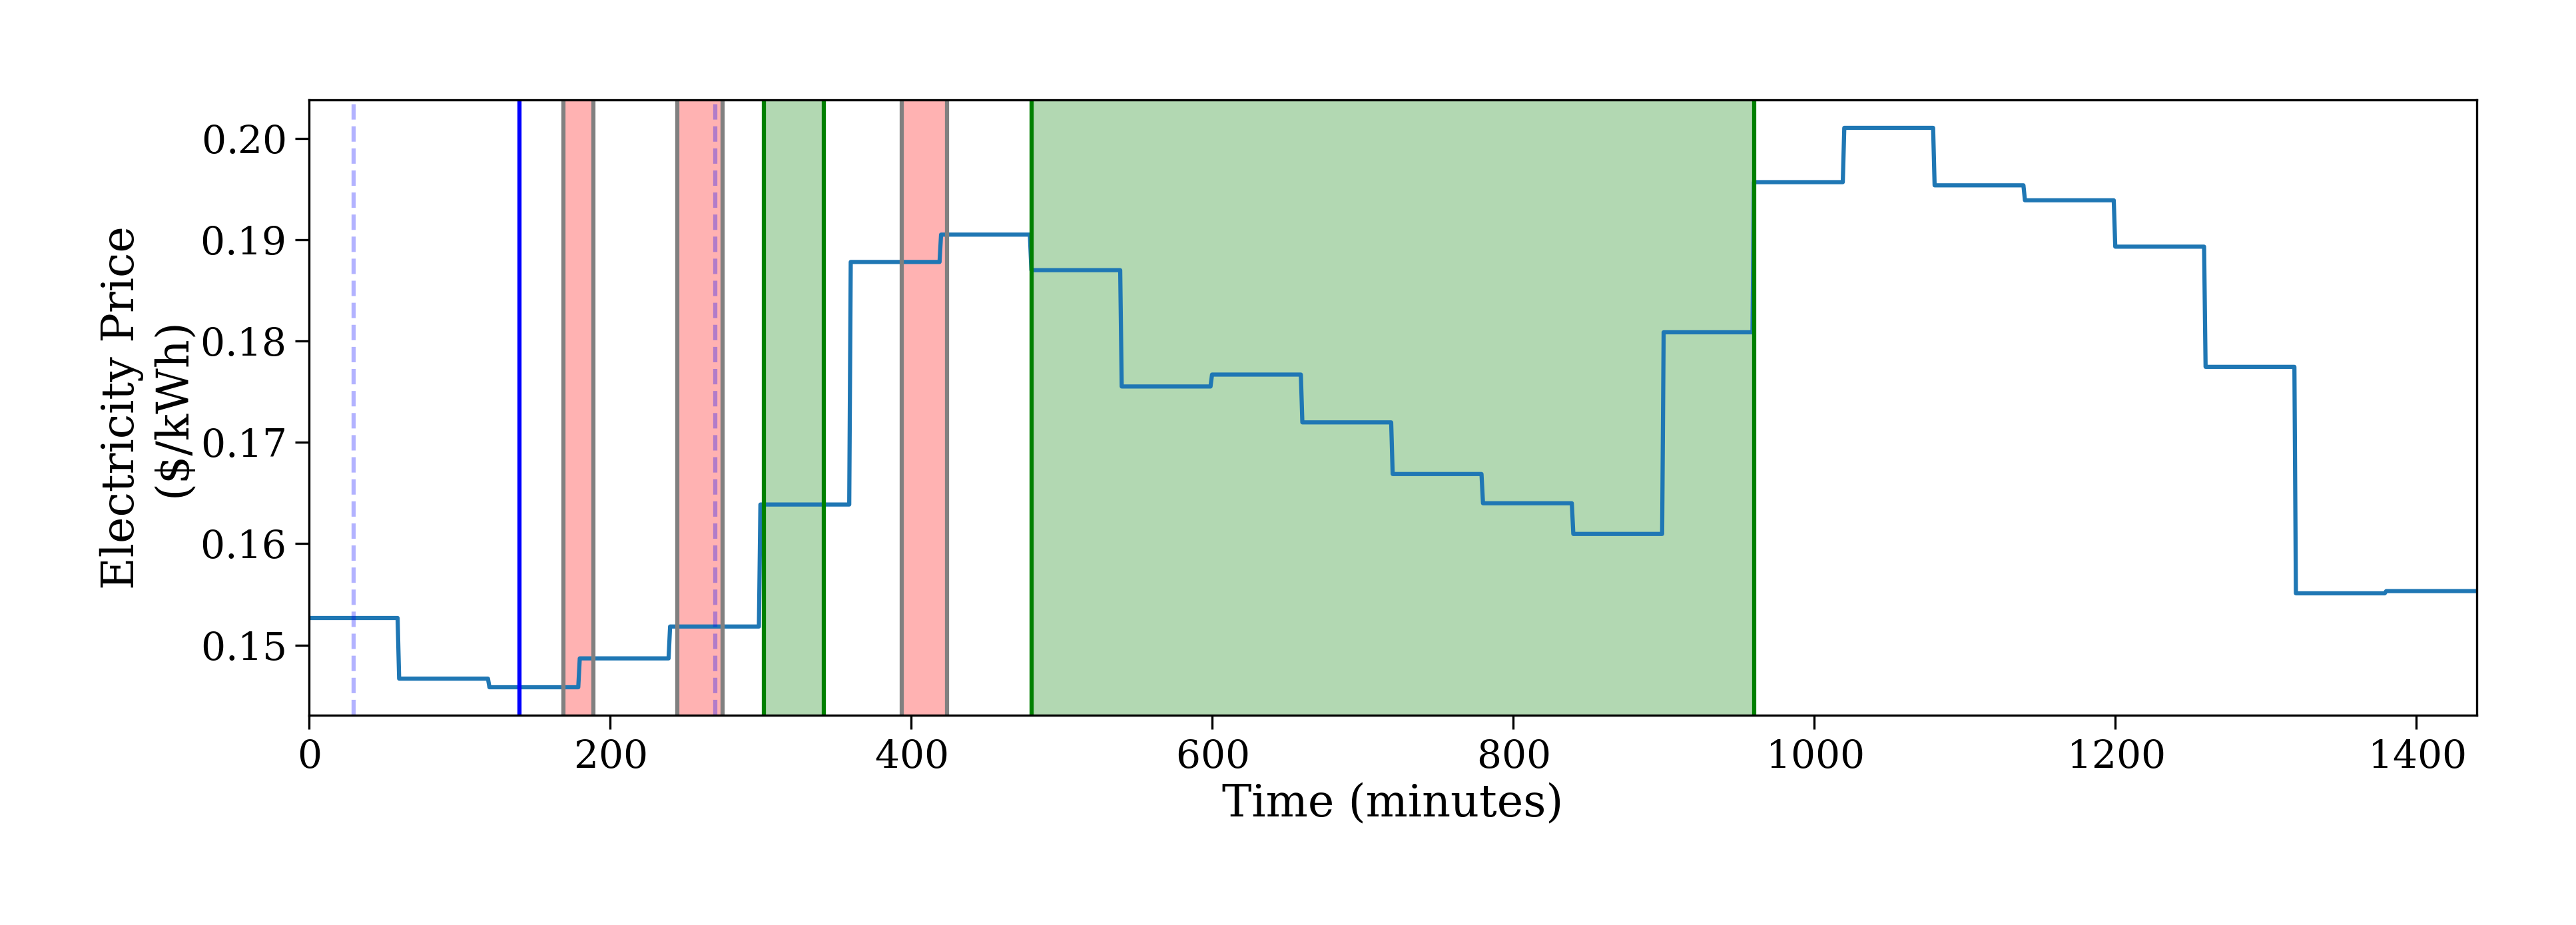

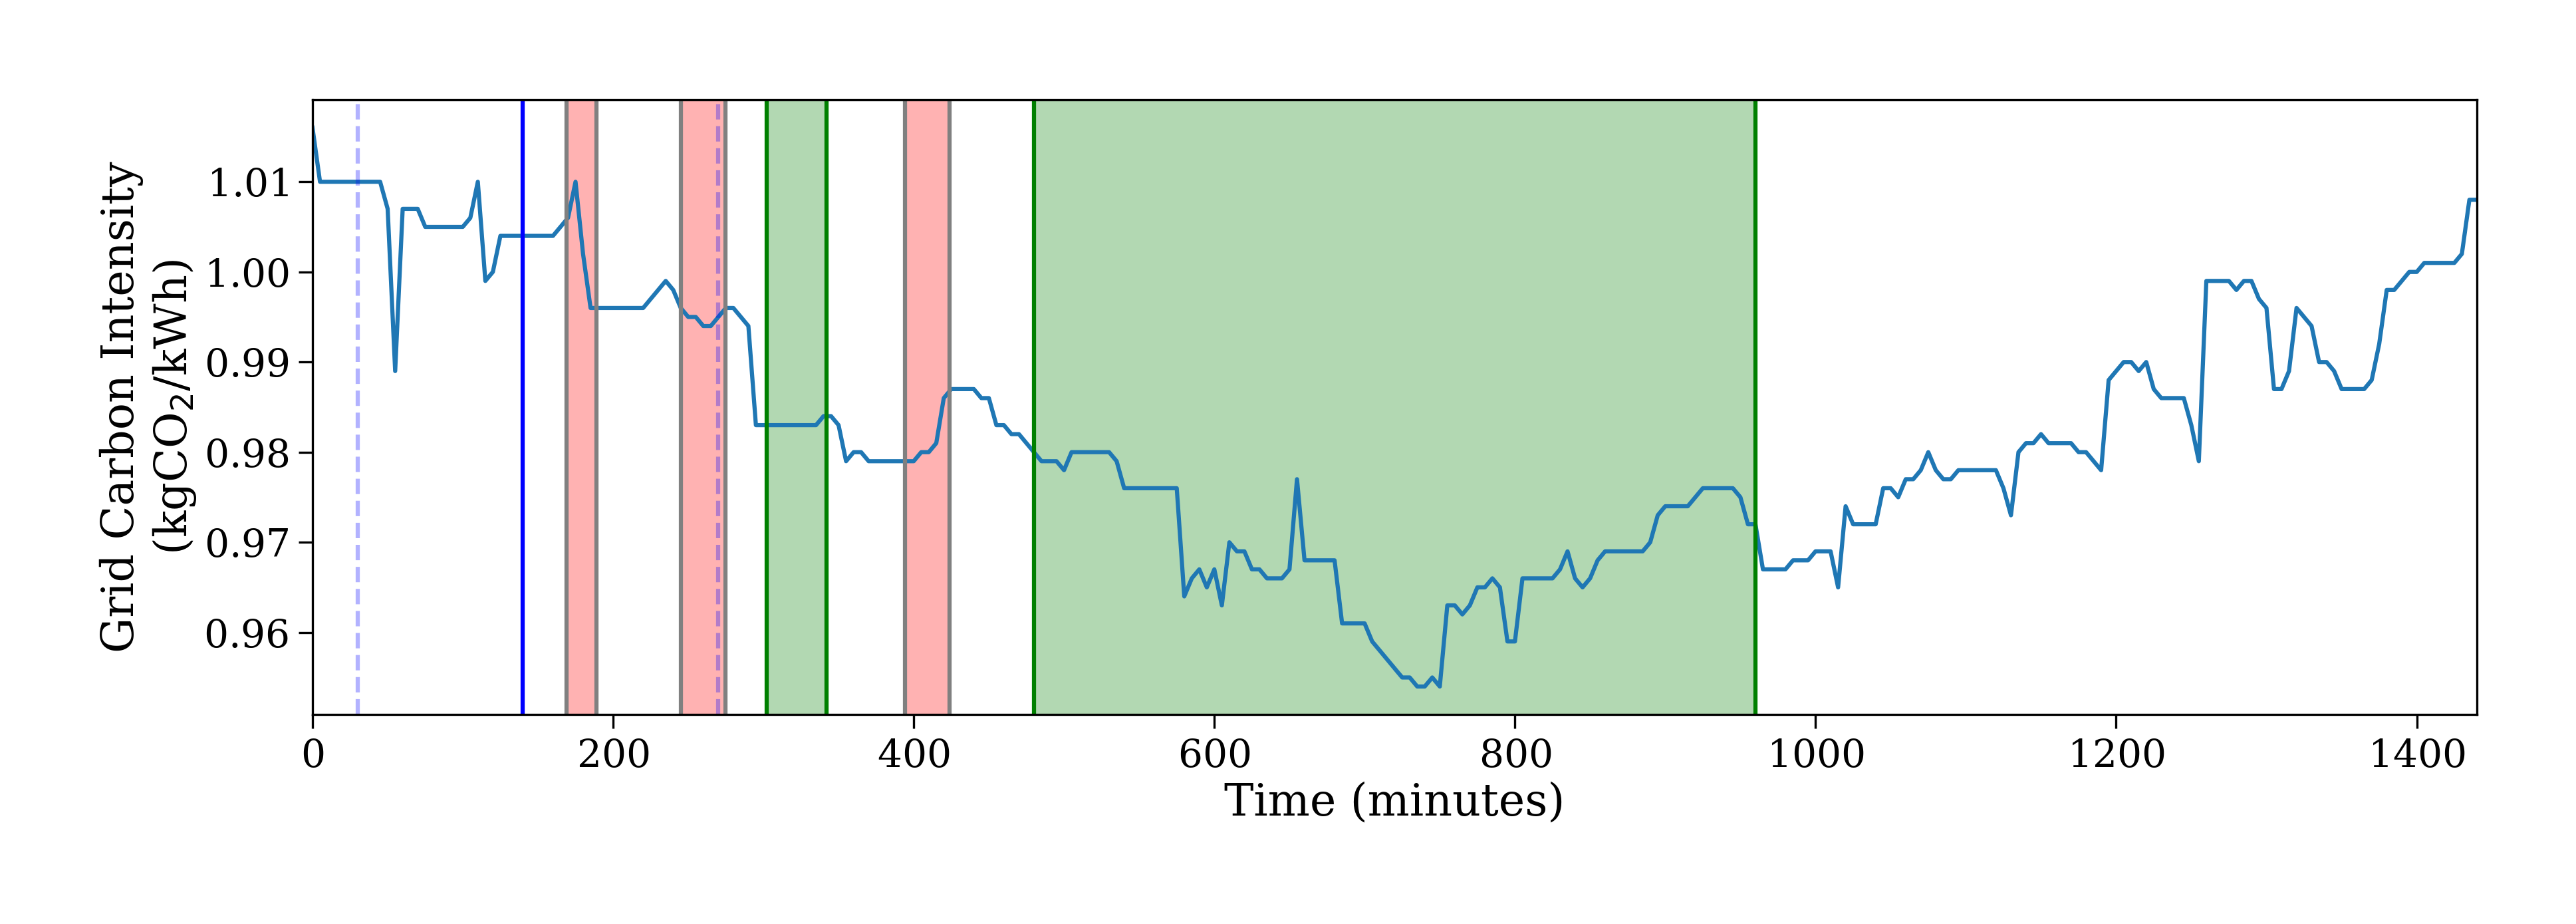

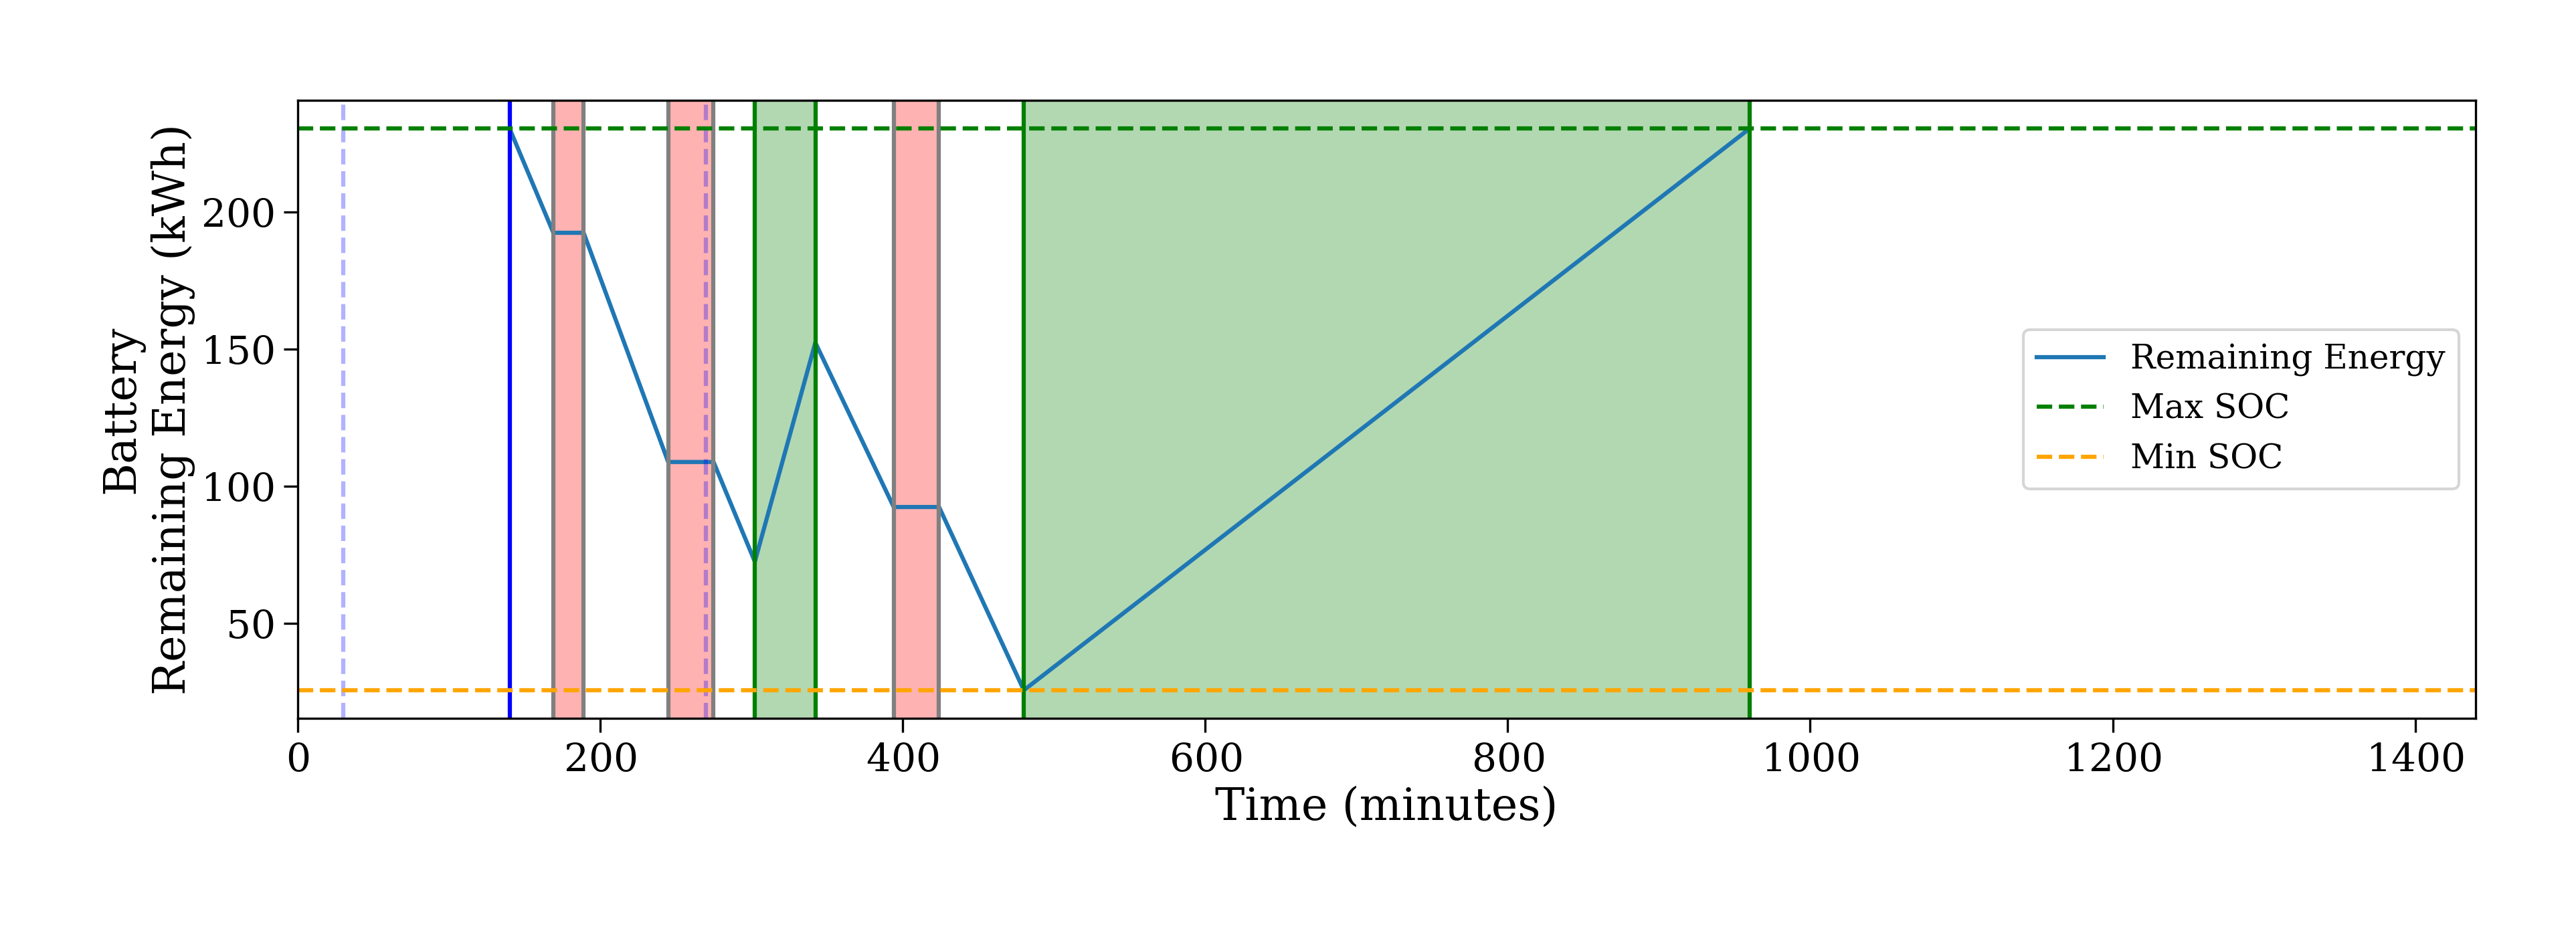

In [12]:
# Plot electricity price
fig1, ax1 = plt.subplots(figsize=(14, 4))
ax1.plot(time_index, electricity_price, label='Electricity Price')

# Mark transition points
for i in range(len(time_list)):
    if time_list[i] == 0:
        ax1.axvline(x=optimized_start_time + time_list[i], color='b', linestyle='-')
    elif can_charge[(i-1) // 2]:
        ax1.axvline(x=optimized_start_time + time_list[i], color='g', linestyle='-')
    else:
        ax1.axvline(x=optimized_start_time + time_list[i], color='grey', linestyle='-')
        if i % 2 == 0:
            ax1.axvspan(optimized_start_time + time_list[i-1], optimized_start_time + time_list[i], facecolor='red', alpha=0.3)
    if time_list[i] != 0 and i % 2 == 0 and can_charge[(i-1) // 2]:
        ax1.axvspan(optimized_start_time + time_list[i-1], optimized_start_time + time_list[i], facecolor='green', alpha=0.3)

# Mark bounds for start time
ax1.axvline(x=start_time_lower_bound, color='b', linestyle='--',alpha=0.3)
ax1.axvline(x=start_time_upper_bound, color='b', linestyle='--',alpha=0.3)

# Set labels
ax1.set_ylabel('Electricity Price\n($/kWh)')
ax1.set_xlabel('Time (minutes)')
ax1.set_xlim(0, 1440)

plt.show()

# Plot grid carbon intensity
fig2, ax2 = plt.subplots(figsize=(14, 4))
ax2.plot(time_index, carbon_intensity, label='Grid Carbon Intensity')

# Mark transition points
for i in range(len(time_list)):
    if time_list[i] == 0:
        ax2.axvline(x=optimized_start_time + time_list[i], color='b', linestyle='-')
    elif can_charge[(i-1) // 2]:
        ax2.axvline(x=optimized_start_time + time_list[i], color='g', linestyle='-')
    else:
        ax2.axvline(x=optimized_start_time + time_list[i], color='grey', linestyle='-')
        if i % 2 == 0:
            ax2.axvspan(optimized_start_time + time_list[i-1], optimized_start_time + time_list[i], facecolor='red', alpha=0.3)
    if time_list[i] != 0 and i % 2 == 0 and can_charge[(i-1) // 2]:
        ax2.axvspan(optimized_start_time + time_list[i-1], optimized_start_time + time_list[i], facecolor='green', alpha=0.3)

# Mark bounds for start time
ax2.axvline(x=start_time_lower_bound, color='b', linestyle='--',alpha=0.3)
ax2.axvline(x=start_time_upper_bound, color='b', linestyle='--',alpha=0.3)

# Set labels
ax2.set_ylabel('Grid Carbon Intensity\n(kgCO$_2$/kWh)')
ax2.set_xlabel('Time (minutes)')
ax2.set_xlim(0, 1440)

plt.show()

# Plot the final results for remaining battery energy
fig3, ax3 = plt.subplots(figsize=(14, 4))
ax3.plot([optimized_start_time + t for t in time_list], remaining_energy_list, label='Remaining Energy')

# Mark transition points and optimized charging windows
for i in range(len(time_list)):
    if time_list[i] == 0:
        ax3.axvline(x=optimized_start_time + time_list[i], color='b', linestyle='-')
    elif can_charge[(i-1) // 2]:
        ax3.axvline(x=optimized_start_time + time_list[i], color='g', linestyle='-')
    else:
        ax3.axvline(x=optimized_start_time + time_list[i], color='grey', linestyle='-')
        if i % 2 == 0:
            ax3.axvspan(optimized_start_time + time_list[i-1], optimized_start_time + time_list[i], facecolor='red', alpha=0.3)
    if time_list[i] != 0 and i % 2 == 0 and can_charge[(i-1) // 2]:
        ax3.axvspan(optimized_start_time + time_list[i-1], optimized_start_time + time_list[i], facecolor='green', alpha=0.3)

# Mark bounds for start time
ax3.axvline(x=start_time_lower_bound, color='b', linestyle='--',alpha=0.3)
ax3.axvline(x=start_time_upper_bound, color='b', linestyle='--',alpha=0.3)

# Plot
ax3.axhline(y=max_soc, color='g', linestyle='--', label='Max SOC')
ax3.axhline(y=min_soc, color='orange', linestyle='--', label='Min SOC')

# Set labels
ax3.set_ylabel('Battery\nRemaining Energy (kWh)')
ax3.set_xlabel('Time (minutes)')
ax3.set_xlim(0, 1440)
ax3.legend()

plt.show()

## Brute Force Check


In [13]:
def brute_force(lambd,electricity_price,carbon_intensity,time_index,start_time_nominal,start_time_lower_bound,start_time_upper_bound,charge_windows):
    #start
    delta_t = 1 # 1-minute intervals
    possible_start_times = np.arange(start_time_lower_bound, start_time_upper_bound + 1, delta_t)  # 1-minute intervals
    carbon_intensity_interp = interp1d(time_index, carbon_intensity, kind='linear', fill_value="extrapolate")

    # Initialize variables to store the optimal start time and its cost
    optimal_start_time = None
    optimal_rounded_start_time = None
    minimal_cost = float('inf')
    minimal_rounded_cost = float('inf')
    # Brute-force search over possible start times
    for start_time in possible_start_times:
        total_cost = 0
        total_rounded_cost = 0

        for (start, end) in charge_windows:
            start_time_adjusted = start_time + start
            end_time_adjusted = start_time + end
            start_time_rounded = round(start_time) + round(start)   # NOTE: count cost from first minute (change with -0.001?)
            end_time_rounded = round(start_time) + round(end) # NOTE: do not count cost from extra minute (change with +/-0.001?)

            # Ensure we are within the bounds of the time_index
            if start_time_adjusted >= time_index[-1] or end_time_adjusted <= time_index[0]:
                continue

            # Calculate the cost within the charging window
            while start_time_adjusted < end_time_adjusted:
                next_interval = start_time_adjusted + delta_t # 1-minute intervals
                if next_interval > end_time_adjusted:
                    next_interval = end_time_adjusted

                # Electricity price is constant within each hour
                current_price_interval = int(start_time_adjusted // delta_t) # 1-minute intervals
                price = electricity_price[current_price_interval]

                # Carbon intensity (interpolated)
                carbon_start = carbon_intensity_interp(start_time_adjusted)
                carbon_end = carbon_intensity_interp(next_interval)
                avg_carbon = (carbon_start + carbon_end) / 2

                # Duration of this segment
                duration = (next_interval - start_time_adjusted) / 60  # converting to hours

                # Incremental cost
                total_cost += (price + lambd * avg_carbon) * duration

                start_time_adjusted = next_interval

            # Calculate the cost within the rounded charging window
            while start_time_rounded < end_time_rounded:
                next_interval = start_time_rounded + delta_t # 1-minute intervals
                if next_interval >= end_time_rounded:
                    next_interval = end_time_rounded

                # Electricity price is constant within each hour
                current_price_interval = int(start_time_rounded // delta_t) # 1-minute intervals
                price = electricity_price[current_price_interval]

                # Carbon intensity (interpolated)
                carbon_start = carbon_intensity_interp(start_time_rounded)
                carbon_end = carbon_intensity_interp(next_interval)
                avg_carbon = (carbon_start + carbon_end) / 2

                # Duration of this segment
                duration = (next_interval - start_time_rounded) / 60  # converting to hours

                # Incremental cost
                #print(f"Cost at {start_time_rounded}:",(price + lambd * avg_carbon) * duration)
                total_rounded_cost += (price + lambd * avg_carbon) * duration

                start_time_rounded = next_interval

        # Update the optimal start time if the current total cost is lower
        if total_cost < minimal_cost:
            minimal_cost = total_cost
            optimal_start_time = start_time
        if total_rounded_cost < minimal_rounded_cost:
            minimal_rounded_cost = total_rounded_cost
            optimal_rounded_start_time = start_time
    # Optimal charge windows
    optimal_charge_windows = []
    optimal_rounded_charge_windows = []
    for i,(start, end) in enumerate(charge_windows):
        start_time_adjusted = optimal_start_time + start
        end_time_adjusted = optimal_start_time + end
        optimal_charge_windows.append((start_time_adjusted,end_time_adjusted))

        start_time_rounded = optimal_rounded_start_time + round(start)
        end_time_rounded = optimal_rounded_start_time + round(end)
        optimal_rounded_charge_windows.append((start_time_rounded,end_time_rounded))

    charge_flag_brute = [0]*1440
    
    for i in range(len(charge_flag)):
        for (a,b) in optimal_rounded_charge_windows:
            if i > a and i < b:
                charge_flag[i] = 1

    return optimized_start_time, minimal_cost , charge_flag

# Set hyperparameter
lambd = 0.18

optimized_start_time_brute, optimized_total_cost_brute , charge_flag_brute = brute_force(lambd,electricity_price,carbon_intensity,time_index,start_time_nominal,start_time_lower_bound,start_time_upper_bound,charge_windows)

brute_windows = window_builder(charge_flag_brute)

print("\nLambda:", lambd)

print("Optimized Start Time:", optimized_start_time_brute)

print("Optimized Total Cost:", optimized_total_cost_brute)

print("Charging windows:", brute_windows)



Lambda: 0.18
Optimized Start Time: 140.0
Optimized Total Cost: 3.005999472083405
Charging windows: [(302, 341), (480, 959)]


## Sceanrio Based on Route scheduler

In [14]:
## Parameters
# Define parameters
eta_c = 0.5  # charging efficiency
eta_d = 0.9  # discharging efficiency
lambd = 0.18  # weight for carbon intensity
C_deg = 0  # degradation cost coefficient
SOC_min = 0.1 * battery_capacity  # minimum SOC
SOC_max = 0.9 * battery_capacity  # maximum SOC
max_charge_power = 50  # kW, maximum charging power
max_discharge_power = 50  # kW, maximum discharging power
C_c_max = 1000  # kVA, maximum capacity of the transformer
delta_t = 1  # minutes, time step size
p_t = electricity_price  # electricity price at each time step
g_t = carbon_intensity  # grid carbon intensity at each time step
# Required charging (given by route scheduler)
SOC_init = SOC_min
SOC_target = 0.5 * battery_capacity  ## Change this one instead of the SOC max

# Define parameters
charging_window = charge_windows[0]
charge_window_start = optimized_start_time + charging_window[0]  # start time of the charging window
charge_window_end = min(1440,optimized_start_time + charging_window[1])  # end time of the charging window
start_idx = int(charge_window_start // delta_t)
end_idx = int(charge_window_end // delta_t)
T = end_idx - start_idx  # number of time steps
delta_t = 1  # minutes, time step size
print(start_idx,end_idx)
n = T

p_t = electricity_price[start_idx:end_idx+1]  # electricity price at each time step
g_t = carbon_intensity[start_idx:end_idx+1]  # grid carbon intensity at each time step

302 342


In [15]:
def baseline(T, delta_t,battery_capacity,eta_c,max_charge_power,SOC_min,SOC_max,SOC_init,SOC_target):

    charging_duration = 60 * (SOC_target - SOC_init) / (max_charge_power * eta_c) 
    baseline_c_t = [50 if i < charging_duration else 0 for i in range(T)]
    baseline_d_t = [0] * T



    return baseline_c_t, baseline_d_t

baseline_c_t,baseline_d_t = baseline(T, delta_t,battery_capacity,eta_c,max_charge_power,SOC_min,SOC_max,SOC_init,SOC_target)
print("Optimized Charging Schedule:", baseline_c_t)
print("Optimized Discharging Schedule:", baseline_d_t)



charge_flag_base = winows_lower(baseline_c_t,mip_windows[0],charge_flag)
d_t_base = [0] * len(charge_flag_base)

Optimized Charging Schedule: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Optimized Discharging Schedule: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Lower Level Scheduler

## Linear Programming

In [92]:
def lp(p_t, g_t, T, delta_t,battery_capacity,eta_c,eta_d,C_deg,max_charge_power,max_discharge_power,C_c_max,SOC_min,SOC_max,SOC_init,SOC_target = None,SOC_range=None):
    # Define parameters
    if SOC_range is None and SOC_target is None:
        raise ValueError("Provide either SOC_target or SOC_range.")
    lambd = 0.18  # weight for carbon intensity


    # Assume these are given or calculated previously
    L_net = np.zeros(T)  # net load at each time step
    SOC_togo = 0  # kWh, required SOC to complete the route
    # Define the optimization problem
    prob = pulp.LpProblem("LowLevelChargeScheduler", pulp.LpMinimize)

    # Define decision variables
    c_t = pulp.LpVariable.dicts("c_t", range(T), lowBound=0, upBound=max_charge_power)
    d_t = pulp.LpVariable.dicts("d_t", range(T), lowBound=0, upBound=max_discharge_power)
    omega_t = pulp.LpVariable.dicts("omega_t", range(T), cat='Binary')

    # Define SOC variable and initial SOC
    SOC = [pulp.LpVariable(f"SOC_{t}", lowBound=SOC_min, upBound=SOC_max) for t in range(T + 1)]
    SOC[0] = SOC_init

    # Objective function
    objective = pulp.lpSum([
    (p_t[t] * (c_t[t] * eta_c - d_t[t] * eta_d) + lambd * g_t[t] * (c_t[t] * eta_c - d_t[t] * eta_d)) * (delta_t / 60) + C_deg * d_t[t]
    for t in range(T)
    ])
    prob += objective

    # SOC dynamics and constraints
    for t in range(T):
        prob += SOC[t + 1] == SOC[t] + (c_t[t] * eta_c - d_t[t] * eta_d) * (delta_t / 60)
        prob += c_t[t] <= max_charge_power * omega_t[t]
        prob += d_t[t] <= max_discharge_power * (1 - omega_t[t])

    # Net load constraint
    for t in range(T):
        prob += L_net[t] + c_t[t] * eta_c - d_t[t] * eta_d <= C_c_max

    # Window SOC constraint
    if SOC_range is not None:
        lo, hi = SOC_range
        prob += SOC[T] >= lo
        prob += SOC[T] <= hi
    else:
        print(SOC_target)
        prob += SOC[T] >= SOC_target

    # Solve the problem
    prob.solve()

    # Retrieve the optimized schedules
    optimized_c_t = [pulp.value(c_t[t]) for t in range(T)]
    optimized_d_t = [pulp.value(d_t[t]) for t in range(T)]
    optimized_SOC = [pulp.value(SOC[t]) for t in range(T + 1)]


    return optimized_c_t, optimized_d_t, optimized_SOC




optimized_c_t, optimized_d_t, optimized_SOC = lp(p_t, g_t, T, delta_t,battery_capacity,eta_c,eta_d,C_deg,max_charge_power,max_discharge_power,C_c_max,SOC_min,SOC_max,SOC_init,SOC_target)


charge_flag_new_mip = winows_lower(optimized_c_t,mip_windows[1],charge_flag)
d_t_milp = winows_lower(optimized_d_t,mip_windows[1],charge_flag)


print("Optimized Charging Schedule:", optimized_c_t)
print("Optimized Discharging Schedule:", optimized_d_t)
print("Optimized SOC:", optimized_SOC)


128.0
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l_/9_zfnc1528j4t0x96tq52wdh0000gn/T/ea4bdf737a234675a1754fae7ff84684-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l_/9_zfnc1528j4t0x96tq52wdh0000gn/T/ea4bdf737a234675a1754fae7ff84684-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1926 COLUMNS
At line 8647 RHS
At line 10569 BOUNDS
At line 12970 ENDATA
Problem MODEL has 1921 rows, 1920 columns and 4800 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 34.5264 - 0.01 seconds
Cgl0004I processed model has 1424 rows, 1903 columns (480 integer (480 of which binary)) and 3806 elements
Cbc0038I Initial state - 1 integers unsatisfied sum - 0.228571
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 34.6203 iterations 292
Cbc0038I 

## Brute Force

In [90]:
def brute_lower(p_t, g_t, T, delta_t,battery_capacity,eta_c,eta_d,C_deg,max_charge_power,max_discharge_power,C_c_max,SOC_min,SOC_max,SOC_init,SOC_target):
    # Define parameters
    lambd = 0.18  # weight for carbon intensity

    delta_t = 1  # minutes, time step size


    # Determine minimum charging steps
    min_target_charging = SOC_target - SOC_init
    min_charging_steps = math.floor(min_target_charging/max_charge_power/(delta_t/60))
    total_cost_delta = p_t[start_idx:end_idx + 1] + lambd*g_t[start_idx:end_idx + 1]

    charging_duration = 60 * (SOC_target - SOC_init) / (max_charge_power * eta_c) 



    indexed_list = list(enumerate(total_cost_delta))  # [(0, 12), (1, 5), ..., (13, 10)]


    sorted_by_value = sorted(indexed_list, key=lambda x: x[1])

    smallest_indices = [index for index, value in sorted_by_value[:int(charging_duration)+1]]
    brute_force_c_t = [0]*T  # Plug in your brute-force charging profile
    for i in smallest_indices:
        brute_force_c_t[i] = 50
    
    brute_force_d_t = [0]*T # Plug in your brute-force discharging profile 


    SOC_scheduled = [SOC_min + sum(brute_force_c_t[:i+1])*1/60 for i in range(len(brute_force_c_t))]
    time_array = [charge_window_start + t * delta_t for t in range(T + 1)]
    for i in range(len(SOC_scheduled)):

        if SOC_scheduled[i]>SOC_max:
            remaining_charge = SOC_max - SOC_scheduled[i-1]
            remaining_charge_time = 60 * remaining_charge/max_charge_power
            if remaining_charge_time!=0:
                time_array.insert(i,time_array[i-1] + remaining_charge_time)
                SOC_scheduled.insert(i,SOC_scheduled[i-1] + max_charge_power*remaining_charge_time/60)
            else:
                SOC_scheduled[i] = SOC_scheduled[i-1]
    SOC_scheduled[-1] = SOC_scheduled[-2]


    # print("brute_force_c_t: ",brute_force_c_t)
    return brute_force_c_t, brute_force_d_t, SOC_scheduled


brute_force_c_t, brute_force_d_t, SOC_scheduled = brute_lower(p_t, g_t, T, delta_t,battery_capacity,eta_c,eta_d,C_deg,max_charge_power,max_discharge_power,C_c_max,SOC_min,SOC_max,SOC_init,SOC_target)

charge_flag_new_brute = winows_lower(brute_force_c_t,brute_windows[1],charge_flag)

d_t_brute = [0] * len(charge_flag_new_brute)

print("Optimized Charging Schedule:", brute_force_c_t)
print("Optimized Discharging Schedule:", brute_force_d_t)
print("Optimized SOC:", SOC_scheduled)


Optimized Charging Schedule: [50, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

## Bellman-Ford

In [87]:
def bellman_ford_schedule(p_t, g_t, T, delta_t, 
                          SOC_init, battery_capacity, 
                          C_c_max,SOC_min,SOC_max, max_charge_power, max_discharge_power, 
                          eta_c, eta_d, lambd, C_deg,SOC_target = None,SOC_range=None,resolution=1.0):
    if SOC_range is None and SOC_target is None:
        raise ValueError("Provide either SOC_target or SOC_range.")
    
    # Pre-calculate energy per minute (in kWh)
    energy_rate = 50 * (delta_t / 60.0)  # same for charging; for discharging, we later apply efficiency

    # Initialize dynamic programming tables:
    # dp[t] is a dictionary mapping SOC (rounded to resolution) to minimal cost to get there at time t.
    dp = [{} for _ in range(T + 1)]
    dp[0][round(SOC_init, 2)] = 0  # starting at t=0 with SOC_init and zero cost.

    # To backtrack the decisions, store predecessors.
    predecessor = [{} for _ in range(T + 1)]
    
    # Define the three possible actions.
    # For each action, we compute the SOC change over one minute.
    # Note: In our cost function, the net energy change for charging/discharging is:
    #    net_energy = (power * efficiency), where power is always 50 kW (converted to kWh per minute).
    actions = {
        'charge': {
            # 'soc_change': energy_rate * eta_c,       # Increase by energy_rate*eta_c kWh
            'soc_change': energy_rate * eta_c,       # Increase by energy_rate*eta_c kWh
            'degradation': 0,                         # No degradation cost for charging
            'multiplier': 1,
        },
        'discharge': {
            'soc_change': -energy_rate * eta_d ,        # Decrease by energy_rate*eta_d kWh
            'degradation': C_deg * max_discharge_power, # Degradation cost penalty
            'multiplier': 1,
        },
        'idle': {
            'soc_change': 0,
            'degradation': 0,
            'multiplier': 0,
        }
    }
    
    # Iterate over each time step in the planning horizon.
    for t in range(T):
        # Loop over each state (SOC) reached at time step t.
        for soc in list(dp[t].keys()):
            current_cost = dp[t][soc]
            
            # Try each action.
            for action, params in actions.items():
                new_soc = soc + params['soc_change']
                
                # Check SOC feasibility (keeping within physical bounds)
                if new_soc < SOC_min or new_soc > SOC_max:
                    continue  # discard this transition if it violates limits
                
                # Round new_soc to reduce floating-point issues.
                new_soc = round(new_soc, 3)
                
                # Compute the net energy transferred (in kWh) with its sign.
                net_energy = params['soc_change']  # positive for charge, negative for discharge, zero for idle
                if net_energy > C_c_max:
                    continue  # discard this transition if it violates limits
                # Compute the cost incurred at time t for taking this action.
                # Cost components: 
                #   (i) energy cost: p_t[t] * net_energy
                #  (ii) carbon cost: lambd * g_t[t] * net_energy
                #  (iii) degradation cost if discharging: provided by params['degradation']
                # Multiply by (delta_t/60) to adjust the units.
                base_cost = (p_t[t] * net_energy + lambd * g_t[t] * net_energy) * (delta_t / 60.0) * params['multiplier']
                transition_cost = base_cost + params['degradation']
                # transition_cost = base_cost 

                total_cost = current_cost + transition_cost
                
                # Update the DP table for time t+1 if this transition offers a lower cost.
                if new_soc not in dp[t + 1] or total_cost < dp[t + 1][new_soc]:
                    dp[t + 1][new_soc] = total_cost
                    predecessor[t + 1][new_soc] = (soc, action)
    
    # Terminal: look for any state at time T that meets the target SOC (within a small tolerance)
    tolerance = resolution
    if SOC_range is not None:
        lo, hi = SOC_range
        def admissible(s): return (lo - tolerance) <= s <= (hi + tolerance)
    else:
        target = SOC_target
        def admissible(s): return abs(s - target) <= tolerance
    best_soc = None
    best_cost = float('inf')
    for soc, cost in dp[T].items():
        if admissible(soc) and cost < best_cost:
            best_cost = cost
            best_soc = soc
    if best_soc is None:
        print("No feasible solution that reaches the target SOC was found.")
        return None, None
    
    # Backtracking to retrieve the optimal schedule.
    schedule = []
    soc = best_soc
    for t in range(T, 0, -1):
        prev_soc, action = predecessor[t][soc]
        schedule.append((t - 1, action, prev_soc, soc))
        soc = prev_soc
    schedule.reverse()  # The schedule is built backward so reverse it for chronological order.
    

    return best_cost, schedule


# Run the Bellman-Ford–like algorithm to compute the optimal schedule.
best_cost, schedule = bellman_ford_schedule(p_t, g_t, T, delta_t,
                                             SOC_init, battery_capacity,
                                             C_c_max,SOC_min,SOC_max, max_charge_power, max_discharge_power,
                                             eta_c, eta_d, lambd, C_deg, SOC_target= SOC_target,resolution=1.0)

if schedule is not None:
    print("Optimal cost: {:.4f}".format(best_cost))
    print("Schedule (time index, action, previous SOC, new SOC):")
    for entry in schedule:
        print(entry)
else:
    print("No feasible schedule found.")


Optimal cost: 0.5692
Schedule (time index, action, previous SOC, new SOC):
(0, 'charge', 25.6, 26.017)
(1, 'charge', 26.017, 26.434)
(2, 'charge', 26.434, 26.851)
(3, 'charge', 26.851, 27.268)
(4, 'charge', 27.268, 27.685)
(5, 'charge', 27.685, 28.102)
(6, 'charge', 28.102, 28.519)
(7, 'charge', 28.519, 28.936)
(8, 'charge', 28.936, 29.353)
(9, 'charge', 29.353, 29.77)
(10, 'charge', 29.77, 30.187)
(11, 'charge', 30.187, 30.604)
(12, 'charge', 30.604, 31.021)
(13, 'charge', 31.021, 31.438)
(14, 'charge', 31.438, 31.855)
(15, 'charge', 31.855, 32.272)
(16, 'charge', 32.272, 32.689)
(17, 'charge', 32.689, 33.106)
(18, 'charge', 33.106, 33.523)
(19, 'charge', 33.523, 33.94)
(20, 'charge', 33.94, 34.357)
(21, 'charge', 34.357, 34.774)
(22, 'charge', 34.774, 35.191)
(23, 'charge', 35.191, 35.608)
(24, 'charge', 35.608, 36.025)
(25, 'charge', 36.025, 36.442)
(26, 'charge', 36.442, 36.859)
(27, 'discharge', 36.859, 36.109)
(28, 'discharge', 36.109, 35.359)
(29, 'discharge', 35.359, 34.609)
(3

In [93]:
def calculate_total_cost(c_t, d_t, p_t, g_t, eta_c, eta_d, lambd, C_deg, delta_t):
    total_cost = sum([
        (p_t[t] * (c_t[t] * eta_c - d_t[t] * eta_d) + lambd * g_t[t] * (c_t[t] * eta_c - d_t[t] * eta_d)) * (delta_t / 60)
        + C_deg * d_t[t]
        for t in range(len(c_t))
    ])
    return total_cost


def calculate_electricity_cost(c_t, d_t, p_t, g_t, eta_c, eta_d, lambd, C_deg, delta_t):
    electricity_cost = []
    total_cost = 0
    for t in range(len(c_t)):
        cost_at_t = (p_t[t] * (c_t[t] * eta_c - d_t[t] * eta_d)) * (delta_t / 60)
        cost_at_t += C_deg * d_t[t]
        total_cost += cost_at_t
        electricity_cost.append(total_cost)
    return  electricity_cost


def calculate_cumulative_cost(c_t, d_t, p_t, g_t, eta_c, eta_d, lambd, C_deg, delta_t):
    cumulative_cost = []
    total_cost = 0
    for t in range(len(c_t)):
        cost_at_t = (p_t[t] * (c_t[t] * eta_c - d_t[t] * eta_d) + lambd * g_t[t] * (c_t[t] * eta_c - d_t[t] * eta_d)) * (delta_t / 60)
        cost_at_t += C_deg * d_t[t]
        total_cost += cost_at_t
        cumulative_cost.append(total_cost)
    return cumulative_cost


def calculate_sumulative_SOC(c_t, d_t, p_t, g_t, eta_c, eta_d, lambd, C_deg, delta_t,SOC_init):
    cumulative_soc = [SOC_init]
    total_cost = SOC_init
    for t in range(len(c_t)):
        cost_at_t = ((c_t[t] * eta_c - d_t[t] * eta_d )) * (delta_t / 60)
        total_cost += cost_at_t
        cumulative_soc.append(total_cost)
    return cumulative_soc

In [94]:
c_t_bf = [0] * len(schedule)
d_t_bf = [0] * len(schedule)
for i in range(len(schedule)):

    if schedule[i][1] == 'charge':

        c_t_bf[i] = 1
    elif schedule[i][1] == 'discharge':
        d_t_bf[i] = 1

charge_flag_bf = winows_lower(c_t_bf,brute_windows[1],charge_flag)
charge_flag_bf_dis = winows_lower(d_t_bf,brute_windows[1],charge_flag)

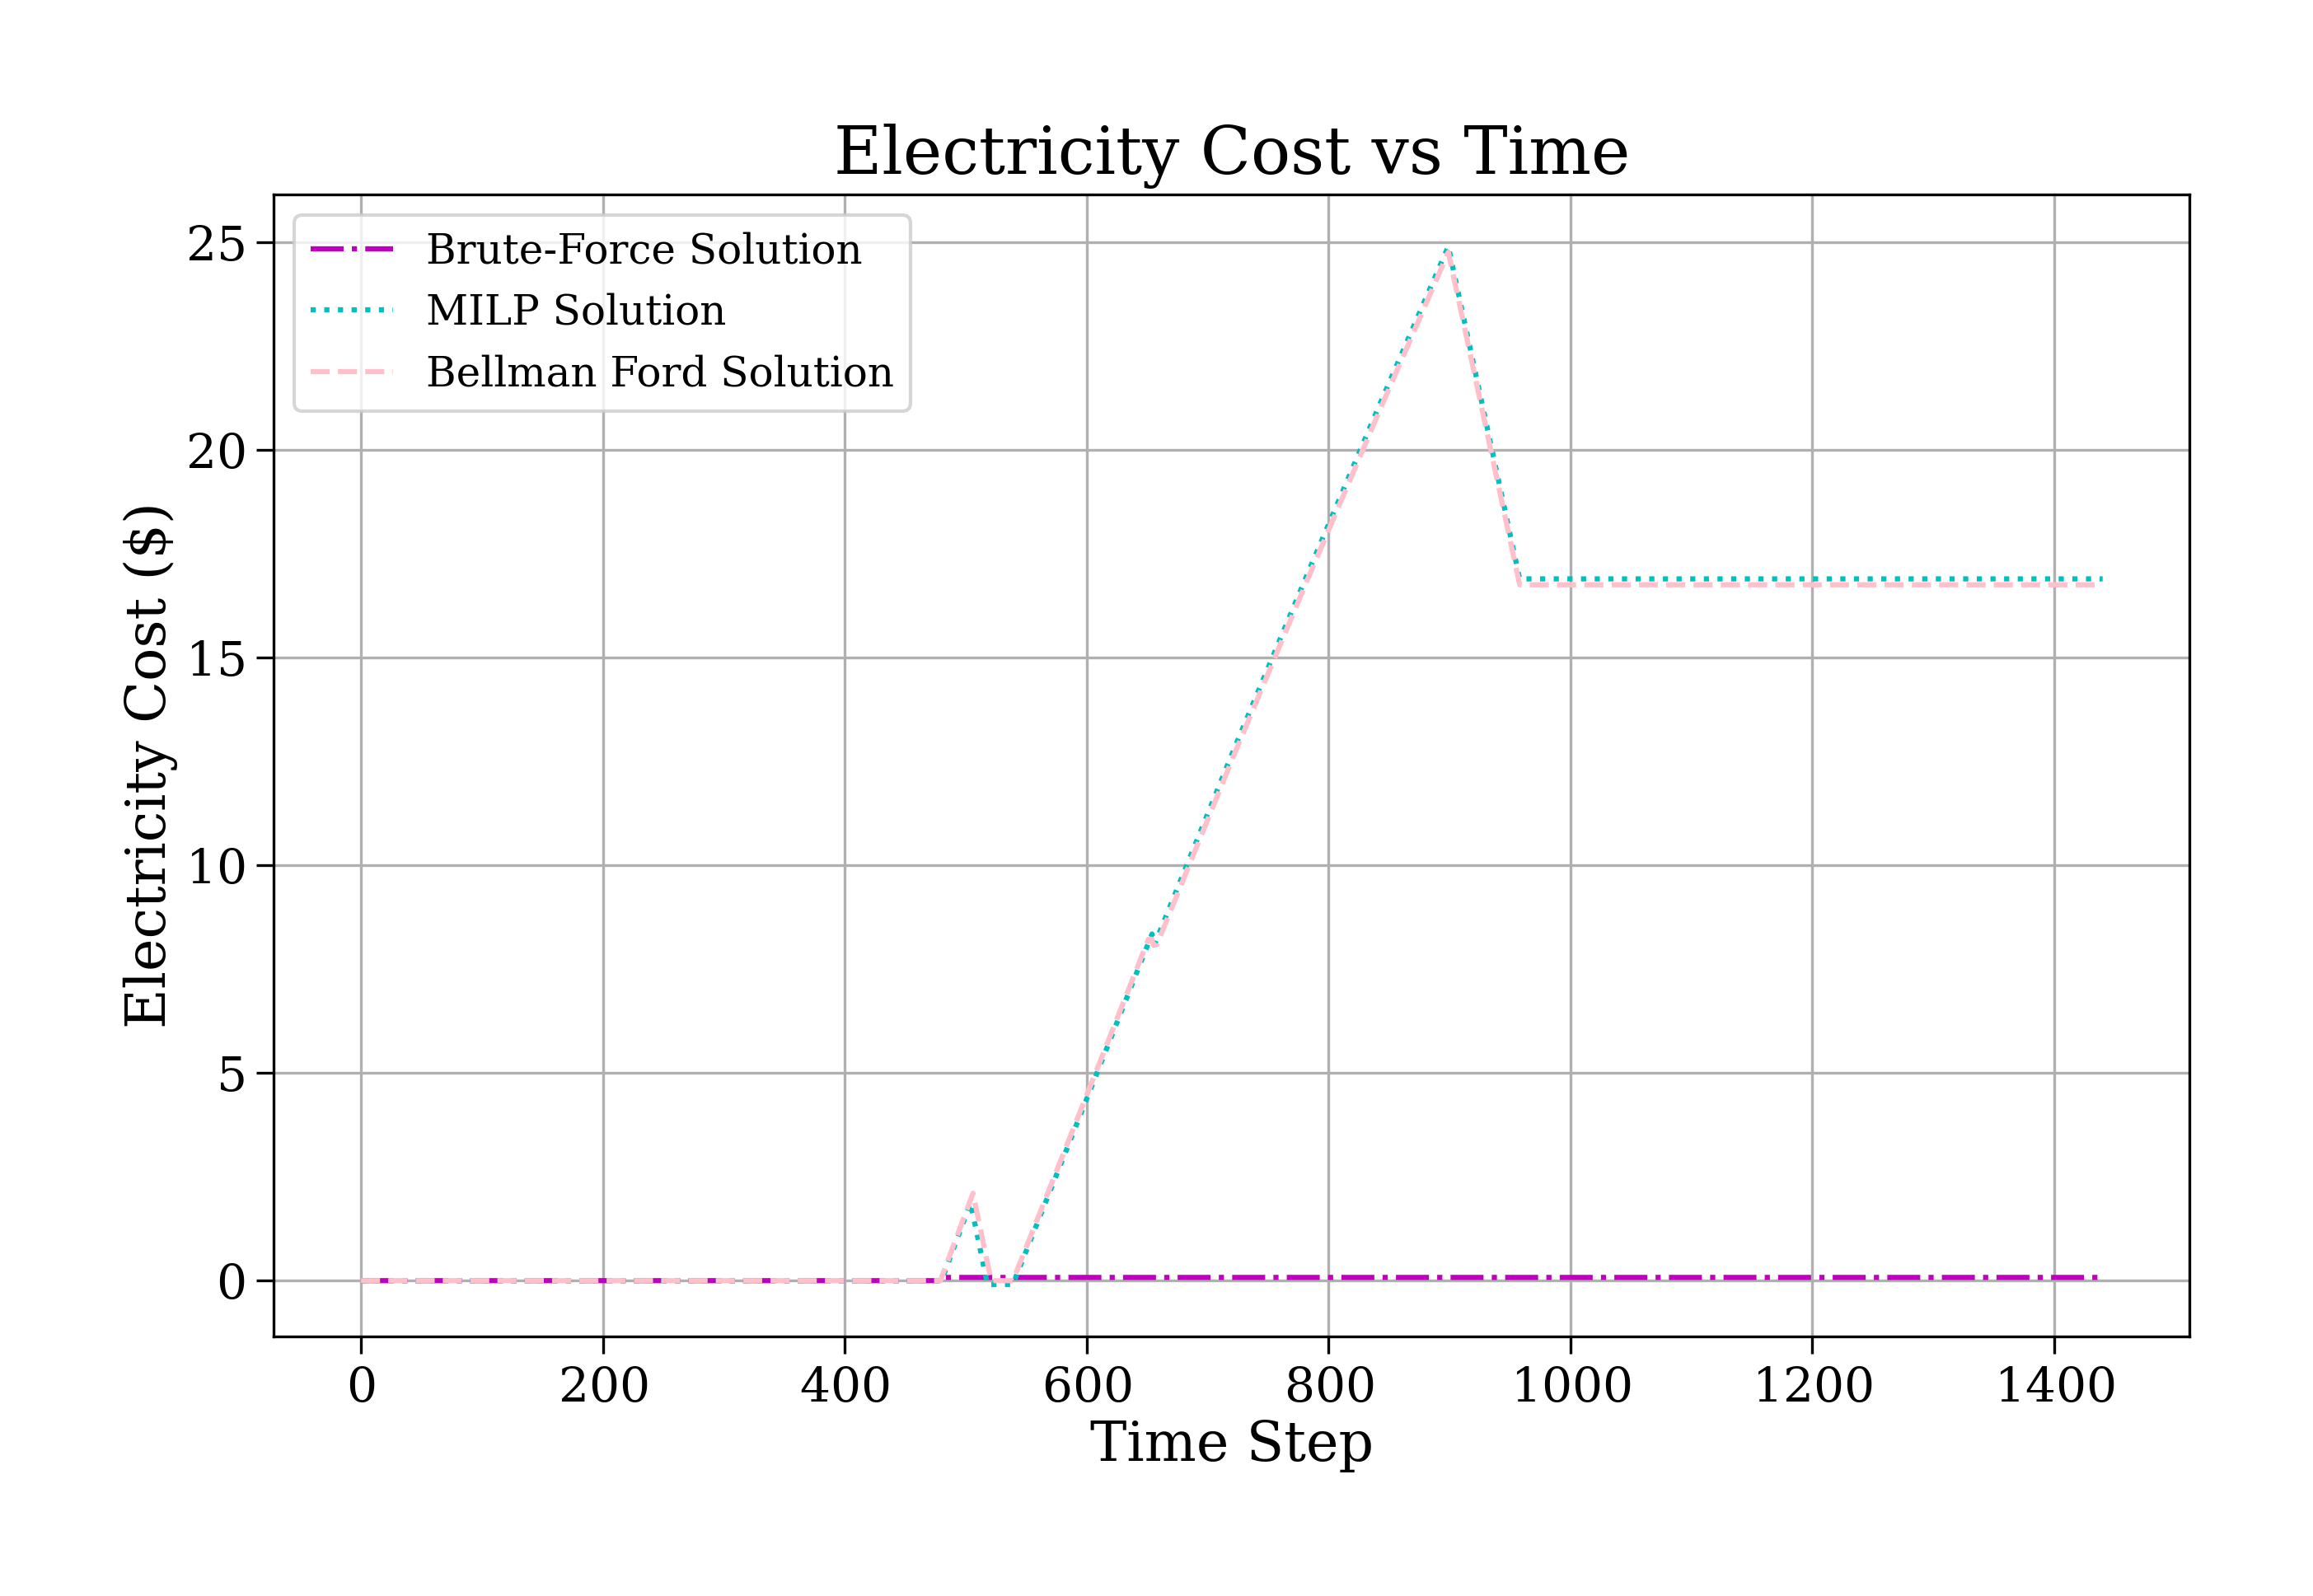

In [97]:
brute_day_long_elec = calculate_electricity_cost(charge_flag_new_brute,d_t_brute, electricity_price, carbon_intensity, eta_c, eta_d, lambd, C_deg, delta_t)
mlp_day_long_elec = calculate_electricity_cost(charge_flag_new_mip, d_t_milp, electricity_price, carbon_intensity, eta_c, eta_d, lambd, C_deg, delta_t)
base_day_long_elec = calculate_electricity_cost(charge_flag_base, d_t_brute, electricity_price, carbon_intensity, eta_c, eta_d, lambd, C_deg, delta_t)
bf_day_long_elec = calculate_electricity_cost(charge_flag_bf, charge_flag_bf_dis, electricity_price, carbon_intensity, eta_c, eta_d, lambd, C_deg, delta_t)
time_steps = list(range(len(charge_flag_new_brute)))




plt.figure(figsize=(10, 6))
plt.plot(time_steps, brute_day_long_elec, label='Brute-Force Solution', color='m', linestyle='-.')
plt.plot(time_steps, mlp_day_long_elec, label='MILP Solution', color='c', linestyle=':')
# plt.plot(time_steps,base_day_long_elec , label='Baseline Solution', color='red', linestyle='--')
plt.plot(time_steps,bf_day_long_elec , label='Bellman Ford Solution', color='pink', linestyle='--')


plt.xlabel('Time Step')
plt.ylabel('Electricity Cost ($)')
plt.title('Electricity Cost vs Time')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [78]:
# brute_force_cumulative_cost = calculate_cumulative_cost(charge_flag_new_brute,d_t_brute, electricity_price, carbon_intensity, eta_c, eta_d, lambd, C_deg, delta_t)
# milp_cumulative_cost = calculate_cumulative_cost(charge_flag_new_mip, d_t_milp, electricity_price, carbon_intensity, eta_c, eta_d, lambd, C_deg, delta_t)
# baseline_cumulative_cost = calculate_cumulative_cost(charge_flag_base, d_t_brute, electricity_price, carbon_intensity,eta_c, eta_d, lambd, C_deg, delta_t)
# # bf_day_long_cumulative_cost = calculate_cumulative_cost(charge_flag_bf, charge_flag_bf_dis, electricity_price, carbon_intensity, eta_c, eta_d, lambd, C_deg, delta_t)


# time_steps = list(range(len(charge_flag_new_brute)))


# plt.figure(figsize=(10, 6))
# plt.plot(time_steps, brute_force_cumulative_cost, label='Brute-Force Solution', color='blue', linestyle='--')
# plt.plot(time_steps, milp_cumulative_cost, label='MILP Solution', color='green', linestyle='-')
# plt.plot(time_steps,baseline_cumulative_cost , label='Baseline Solution', color='red', linestyle='--')
# # plt.plot(time_steps,bf_day_long_cumulative_cost , label='Bellman Ford Solution', color='pink', linestyle='--')


# plt.xlabel('Time Step')
# plt.ylabel('Cumulative Cost ($)')
# plt.title('Cumulative Cost vs Time')
# plt.legend(loc='upper left')
# plt.grid(True)
# plt.show()

In [79]:
# schedule_bf = []
# total_cost = 0
# for t in range(len(charge_flag_bf)):
#     charge_at_t = charge_flag_bf[t]  * (delta_t / 60)
#     total_cost += charge_at_t
#     schedule_bf.append(total_cost)



# time_steps = list(range(len(charge_flag_bf)))


# # plt.figure(figsize=(10, 6))
# plt.plot(time_steps, charge_flag_bf, label='Brute-Force Solution', color='blue', linestyle='--')
# # plt.plot(time_steps, charge_flag_new_mip, label='Brute-Force Solution', color='red', linestyle='--')
# # plt.plot(time_steps, milp_cumulative_cost, label='MILP Solution', color='green', linestyle='-')
# # plt.plot(time_steps,baseline_cumulative_cost , label='Baseline Solution', color='red', linestyle='--')
# # plt.plot(time_steps,bf_day_long_cumulative_cost , label='Bellman Ford Solution', color='pink', linestyle='--')


# # plt.xlabel('Time Step')
# # plt.ylabel('SOC')
# # plt.title('SOC vs Time')
# # plt.legend(loc='upper left')
# # plt.grid(True)
# # plt.show()

In [80]:
def T_builder(cw):
    charge_window_start = optimized_start_time + cw[0]  # start time of the charging window
    charge_window_end = min(1440,optimized_start_time + cw[1])  # end time of the charging window
    start_idx = int(charge_window_start // delta_t)
    end_idx = int(charge_window_end // delta_t)
    T = end_idx - start_idx  # number of time steps
    p_t = electricity_price[start_idx:end_idx+1]  # electricity price at each time step
    g_t = carbon_intensity[start_idx:end_idx+1]  # grid carbon intensity at each time step
    return T,p_t,g_t,start_idx,end_idx

def marker(c_t,charge_flag,a,b):
    j = 0
    for i in range(a,b):
        if c_t[j] > 0:
            charge_flag[i] = 50
        j = j + 1
    
    return charge_flag


In [ ]:
SOC_init = SOC_min
charge_flag_milp = [0] * 1440
discharge_flag_milp = [0] * 1440
for i,cw in enumerate(charge_windows):
    T,p_t,g_t,start_idx,end_idx = T_builder(cw)
    SOC_init = SOC_init + (delta_t / 60.0) * (sum(charge_flag_milp) * eta_c - sum(discharge_flag_milp) * eta_d)
    print(SOC_init)
    low = max(SOC_init - T * (delta_t / 60.0),SOC_min)
    high = min(SOC_init + T * (delta_t / 60.0),SOC_max)
    if i != (len(charge_windows)-1):
        optimized_c_t, optimized_d_t, optimized_SOC = lp(p_t, g_t, T, delta_t,battery_capacity,eta_c,eta_d,C_deg,max_charge_power,max_discharge_power,C_c_max,SOC_min,SOC_max,SOC_init,SOC_target = None,SOC_range=(low,high))

        

    else:
        optimized_c_t, optimized_d_t, optimized_SOC = lp(p_t, g_t, T, delta_t,battery_capacity,eta_c,eta_d,C_deg,max_charge_power,max_discharge_power,C_c_max,SOC_min,SOC_max,SOC_init,SOC_target=SOC_target,SOC_range=None)
        SOC_init = optimized_SOC[-1]
        
    
    charge_flag_milp =  marker(optimized_c_t,charge_flag_milp,start_idx,end_idx)
    discharge_flag_milp =  marker(optimized_d_t,discharge_flag_milp,start_idx,end_idx)
# print(SOC_min+(delta_t / 60.0) * (sum(charge_flag_milp) - sum(discharge_flag_milp)))

25.6
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l_/9_zfnc1528j4t0x96tq52wdh0000gn/T/73d4e8a072fe4a50af1d4207a3f9c6d2-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l_/9_zfnc1528j4t0x96tq52wdh0000gn/T/73d4e8a072fe4a50af1d4207a3f9c6d2-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 167 COLUMNS
At line 729 RHS
At line 892 BOUNDS
At line 1093 ENDATA
Problem MODEL has 162 rows, 160 columns and 401 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is -0.00054 - 0.00 seconds
Cgl0004I processed model has 120 rows, 159 columns (40 integer (40 of which binary)) and 318 elements
Cbc0038I Initial state - 1 integers unsatisfied sum - 0.2
Cbc0038I Solution found of -0.00054
Cbc0038I Relaxing continuous gives -0.00054
Cbc0038I Before m

In [ ]:
SOC_init = SOC_min
charge_flag_bf = [0] * 1440
discharge_flag_bf = [0] * 1440
for i,cw in enumerate(charge_windows):
    # SOC_init = SOC_init + (delta_t / 60.0) * (sum(charge_flag_bf) * eta_c + sum(discharge_flag_bf) * eta_d)
    T,p_t,g_t,start_idx,end_idx = T_builder(cw)
    low = max(SOC_init - T * (delta_t / 60.0),SOC_min)
    high = min(SOC_init + T * (delta_t / 60.0),SOC_max)
    if i != (len(charge_windows)-1):
        best_cost, schedule = bellman_ford_schedule(p_t, g_t, T, delta_t,
                                             SOC_init, battery_capacity,
                                             C_c_max,SOC_min,SOC_max, max_charge_power, max_discharge_power,
                                             eta_c, eta_d, lambd, C_deg,SOC_target=None,SOC_range=(low,high), resolution=1)
        
    else:
        best_cost, schedule = bellman_ford_schedule(p_t, g_t, T, delta_t,
                                             SOC_init, battery_capacity,
                                             C_c_max,SOC_min,SOC_max, max_charge_power, max_discharge_power,
                                             eta_c, eta_d, lambd, C_deg,SOC_target=SOC_target,resolution=1)
    SOC_init = schedule[-1][3]
        
        
    c_t_bf = [0] * len(schedule)
    d_t_bf = [0] * len(schedule)
    for j in range(len(schedule)):

        if schedule[j][1] == 'charge':

            c_t_bf[j] = 1
        elif schedule[j][1] == 'discharge':
            d_t_bf[j] = 1

    charge_flag_bf =  marker(c_t_bf,charge_flag_bf,start_idx,end_idx)
    discharge_flag_bf =  marker(d_t_bf,discharge_flag_bf,start_idx,end_idx)

(39, 'discharge', 26.356, 25.606) 302 342
(479, 'discharge', 127.82, 127.07) 480 960


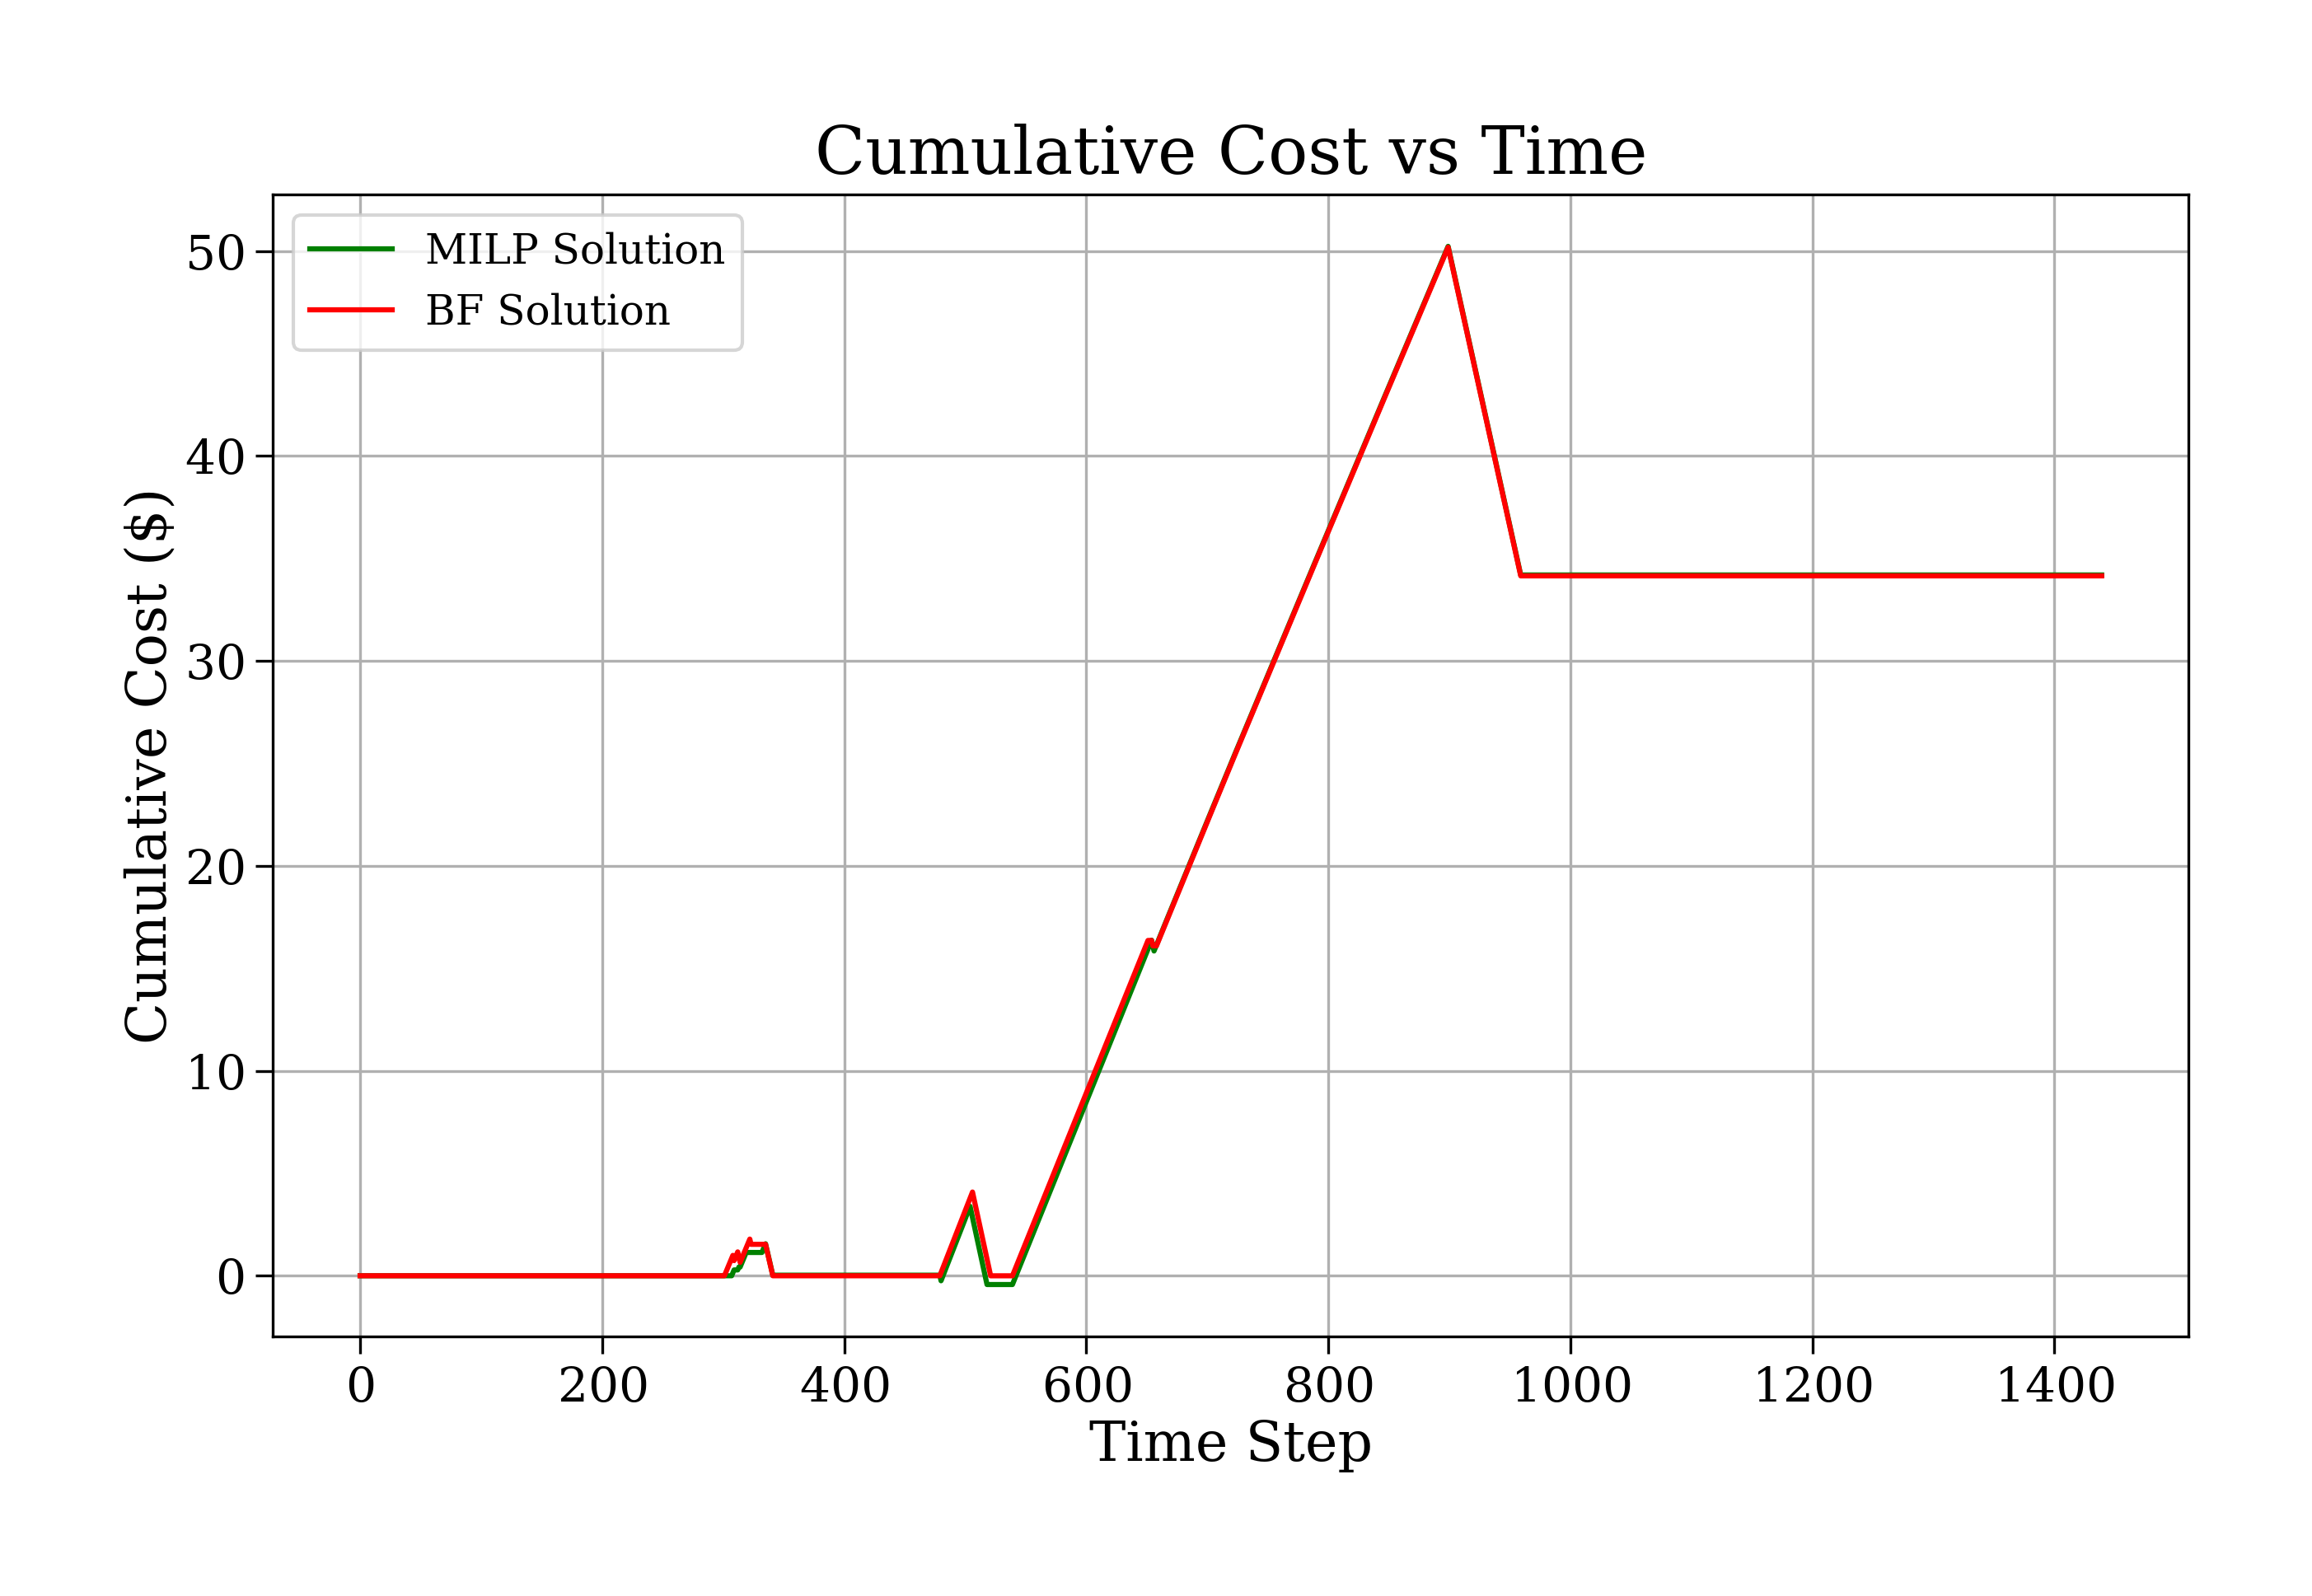

In [116]:
milp_cumulative_cost = calculate_cumulative_cost(charge_flag_milp, discharge_flag_milp, electricity_price, carbon_intensity, eta_c, eta_d, lambd, C_deg, delta_t)
bf_cumulative_cost = calculate_cumulative_cost(charge_flag_bf, discharge_flag_bf, electricity_price, carbon_intensity, eta_c, eta_d, lambd, C_deg, delta_t)


time_steps = list(range(1440))


plt.figure(figsize=(10, 6))
plt.plot(time_steps, milp_cumulative_cost, label='MILP Solution', color='green', linestyle='-')
plt.plot(time_steps, bf_cumulative_cost, label='BF Solution', color='red', linestyle='-')


plt.xlabel('Time Step')
plt.ylabel('Cumulative Cost ($)')
plt.title('Cumulative Cost vs Time')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

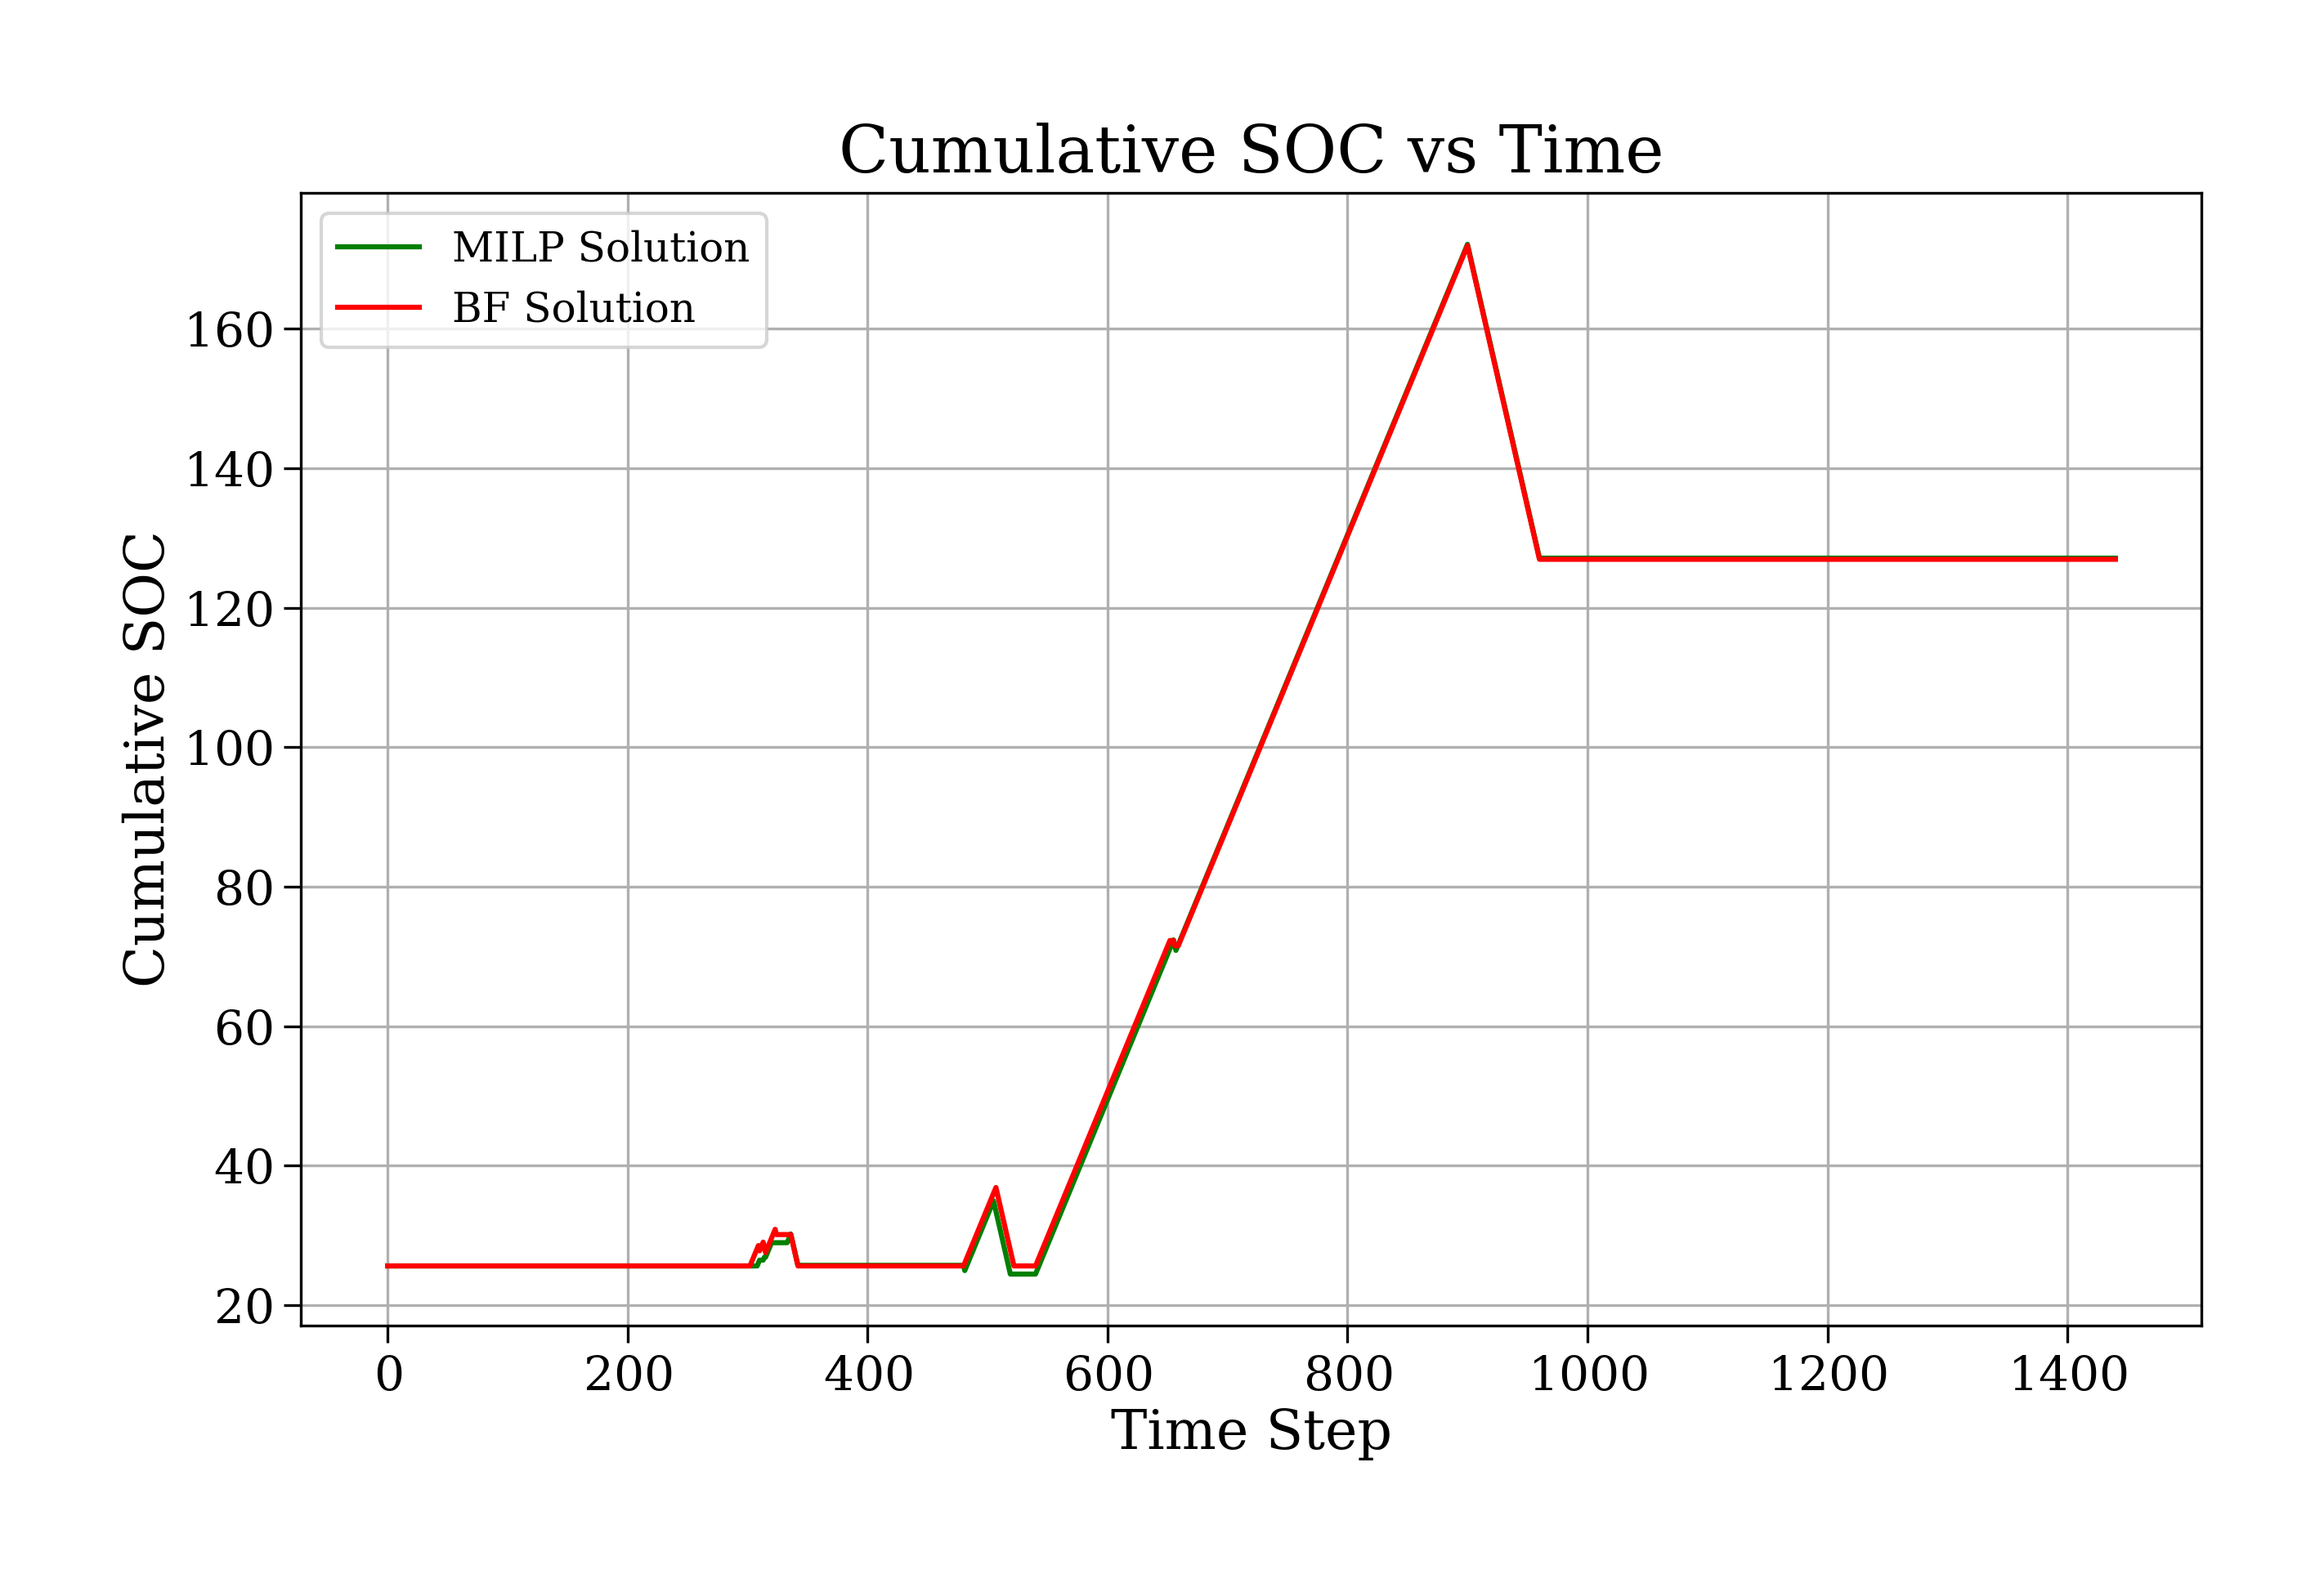

In [117]:
SOC_init = SOC_min
milp_cumulative_soc = calculate_sumulative_SOC(charge_flag_milp, discharge_flag_milp, electricity_price, carbon_intensity, eta_c, eta_d, lambd, C_deg, delta_t,SOC_init)
SOC_init = SOC_min
bf_cumulative_soc = calculate_sumulative_SOC(charge_flag_bf, discharge_flag_bf, electricity_price, carbon_intensity, eta_c, eta_d, lambd, C_deg, delta_t,SOC_init)


time_steps = list(range(1441))


plt.figure(figsize=(10, 6))
plt.plot(time_steps, milp_cumulative_soc, label='MILP Solution', color='green', linestyle='-')
plt.plot(time_steps, bf_cumulative_soc, label='BF Solution', color='red', linestyle='-')


plt.xlabel('Time Step')
plt.ylabel('Cumulative SOC')
plt.title('Cumulative SOC vs Time')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

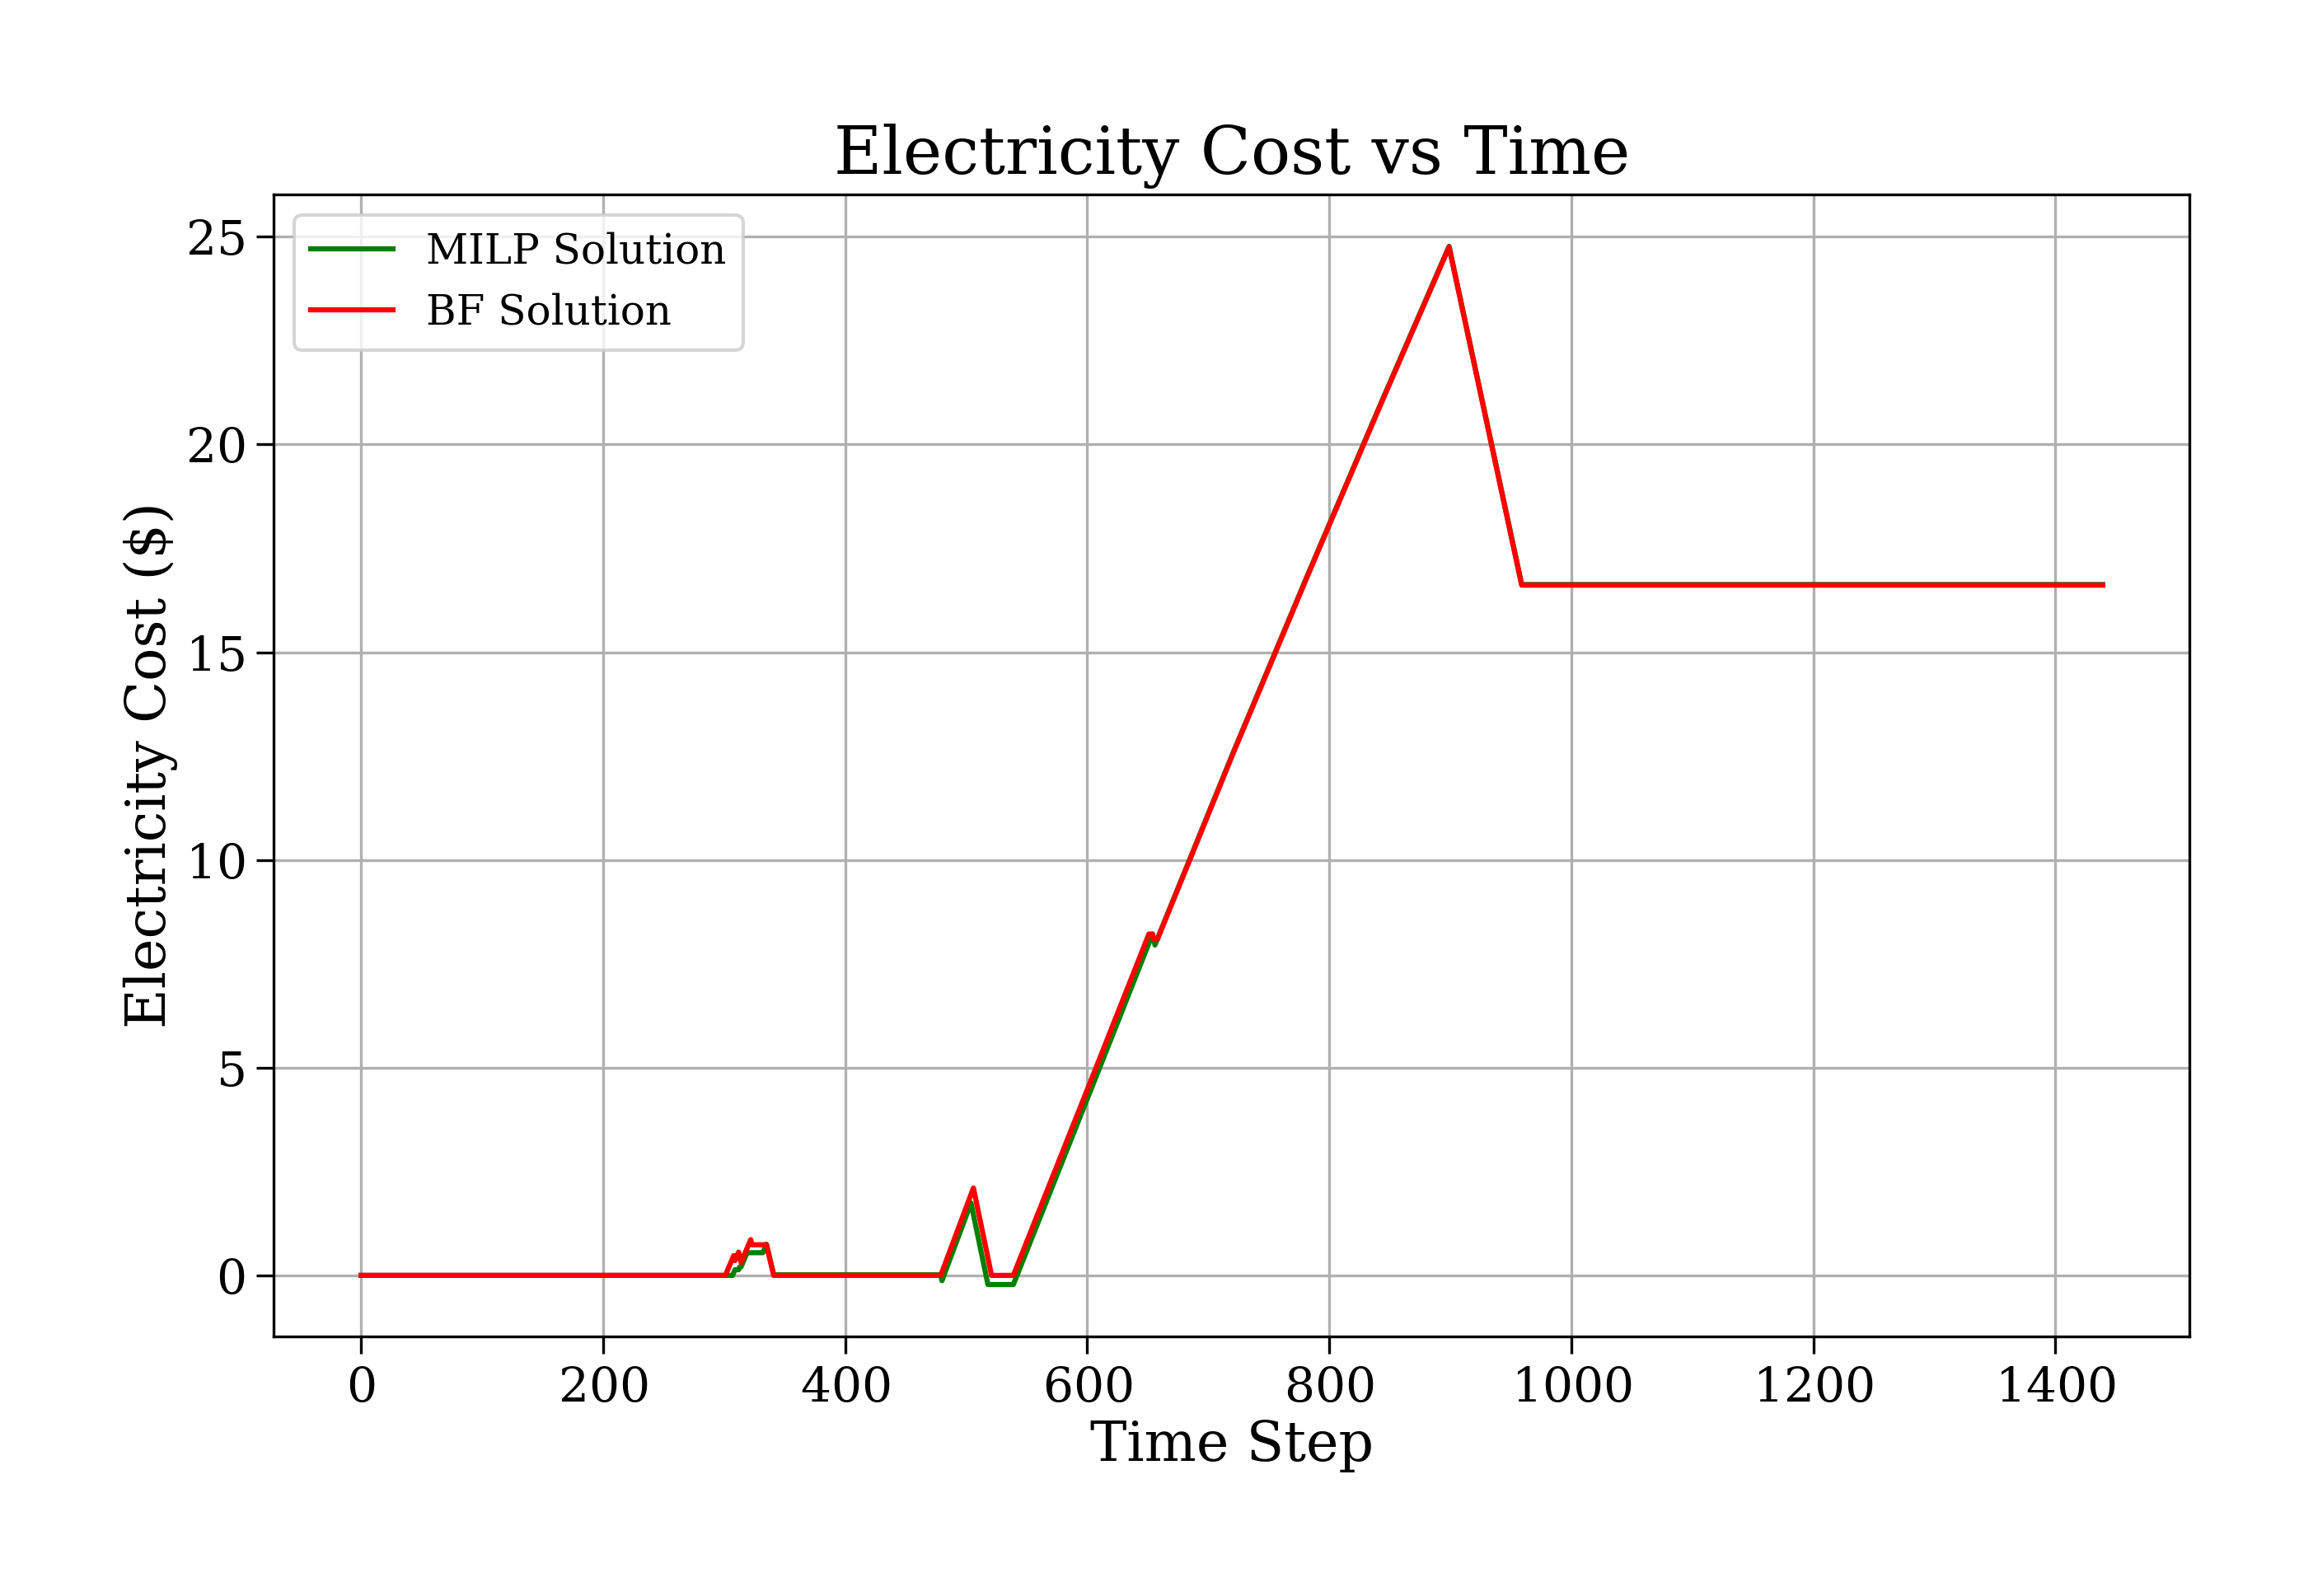

In [118]:
milp_elec_cost = calculate_electricity_cost(charge_flag_milp, discharge_flag_milp, electricity_price, carbon_intensity, eta_c, eta_d, lambd, C_deg, delta_t)
bf_elec_cost = calculate_electricity_cost(charge_flag_bf, discharge_flag_bf, electricity_price, carbon_intensity, eta_c, eta_d, lambd, C_deg, delta_t)


time_steps = list(range(1440))


plt.figure(figsize=(10, 6))
plt.plot(time_steps, milp_elec_cost, label='MILP Solution', color='green', linestyle='-')
plt.plot(time_steps, bf_elec_cost, label='BF Solution', color='red', linestyle='-')


plt.xlabel('Time Step')
plt.ylabel('Electricity Cost ($)')
plt.title('Electricity Cost vs Time')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()